In [1]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, converge_ZNE_order, converge_ZNE_loocv, order_poly_ZNE

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from samplers_util import thermal_rejection
from functions_util import calibrate_sim_Omegas, zero_temperature_Omega, cetina_envelope_exp, calibrate_Js


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
def cetina_envelope_exp(t, theta, Omega):
    """The full Cetina function for the single COM mode
    shots
    
    Args:
    t: float, time
    theta: float, the shift of the gaussian envelope
    Omega: float, the frequency of the gaussian envelope
    
    Returns:
    float: the value of the function at time t
    """
    C = 1/np.sqrt((1 + (Omega*theta*t)**2))
    return  C * np.cos(Omega*t)

In [3]:
to_run = 'old_data'
#to_run = 'new_data'


In [4]:
if to_run == 'new_data':
    #Get the single qubit data:
    file_single = np.load('../data/1_qubit_12_20_r1/data_dump.npz')
    #print all the keys:
    for k in file_single.keys():
        print(k)
    single_Omegas = file_single['Omegas']
    print(single_Omegas)
    Js = single_Omegas[:,0]*single_Omegas[:,1]
    #print(file_single['thetas'])
    print(Js/Js[0])
    #print(Omega/Omega[0])
    #print(J)

In [5]:
# Data generated by Jij_Extrapolation.ipynb
#file = np.load('plotting_data_fig_4_12-3.npz')
file = np.load('plotting_data_fig_4.npz')
#file = np.load('plotting_data_fig_4_12-13_good.npz')
#file = np.load('plotting_data_fig_4_12-3_v2.npz')
if to_run == 'new_data':
    file = np.load('plotting_data_fig_4_12-20_v1.npz')
    slope = 0.0241
    intercept = 0.0528
    t_w = [0.00, 0.122, 0.367, 0.734, 0.979, 1.22, 1.84]
    t_ms = np.array(t_w)/409.6*1e3


#np.savez('Plotting data', times = times, leakage_matrix = leakage_matrix, flopping_matrix = flopping_matrix, flopping_std_matrix = flopping_std_matrix, flopping_matrix_ps = flopping_matrix_ps, flopping_matrix_smooth = flopping_matrix_smooth, flopping_std_matrix_smooth = flopping_std_matrix_smooth, ZNE_data = ZNE_data, ZNE_data_smooth = ZNE_data_smooth, Omega = Omega, decoherence_limit = decoherence_limit)

times = file['times']
theta_list = file['theta_list']
#!!!!!!!!!!!!!!!!!!
if to_run == 'new_data':
    theta_list = slope*t_ms + intercept
#!!!!!!!!!!!!!!!!!!
print('Theta_list')
print(theta_list)
print('Fitted Theta_list')


flopping_ps_smoothed = file['flopping_ps_smoothed']
flopping_std_matrix = file['flopping_std_matrix']
shots = file['shots']
print(shots)
Omega = file['Omega']
flopping_matrix_smooth = file['flopping_matrix_smooth']
flopping_matrix = file['flopping_matrix']
leakage_matrix = file['leakage_matrix']
#remove nans and infs from all of the above:
flopping_matrix = np.nan_to_num(flopping_matrix)
flopping_matrix_smooth = np.nan_to_num(flopping_matrix_smooth)
flopping_ps_smoothed = np.nan_to_num(flopping_ps_smoothed)
flopping_std_matrix = np.nan_to_num(flopping_std_matrix)
leakage_matrix = np.nan_to_num(leakage_matrix)


#import all data:

theta_sub_index = [0, 1, 2, 3, 4, 5]#, 6, 7, 8]
theta_sub_index = [i for i in range(len(theta_list))]#[0,1,2,3,4,5,6]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
print(theta_list[theta_sub_index_mask])
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))
#Make font size 16

ZNE_function = converge_ZNE_loocv
ZNE_function = lambda x, y, weights: converge_ZNE_loocv(x, y, debug=False, y_error=weights, return_cov=True, remove_first=False)

#Get ZNed Data:
ZNE_data_ps = np.zeros(len(times))
ZNE_data_raw = np.zeros(len(times))
ZNE_data_ps_errors = np.zeros(len(times))
ZNE_data_raw_errors = np.zeros(len(times))
ZNE_funcs = []
ZNE_funcs_ps = []
for i in range(30):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func, error = ZNE_function(theta_list[theta_sub_index_mask], flopping_ps_smoothed[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_funcs_ps.append(fit_func)
    ZNE_data_ps[i] = fit_func(0)
    ZNE_data_ps_errors[i] = error
    fit_func, error = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix_smooth[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_funcs.append(fit_func)
    ZNE_data_raw[i] = fit_func(0)
    ZNE_data_raw_errors[i] = error

ZNE_data_smooth_ps = ZNE_data_ps#savgol_filter(ZNE_data_ps, 6, 2)
ZNE_data_smooth = ZNE_data_raw#savgol_filter(ZNE_data_raw, 6, 2)

dense_theta = np.linspace(0, theta_list[theta_sub_index[-1]]+0.02, 25)


Theta_list
[0.05673721 0.06253054 0.07411725 0.09149722 0.10308393 0.11467058
 0.14363726 0.17260395 0.23053732]
Fitted Theta_list
600
[0.05673721 0.06253054 0.07411725 0.09149722 0.10308393 0.11467058
 0.14363726 0.17260395 0.23053732]
[nan, 0.001841050916019409, 0.0015239055751378554, 0.000992668601328904, 0.055947565753062894, 0.06306473634055079, 206.89731863892482, 39749.39847577063]
3
[1 0 0 0]
[[ 8.05213921e-04 -2.10554766e-02  1.62968502e-01 -3.79512862e-01]
 [-2.10554766e-02  5.62205372e-01 -4.42522389e+00  1.04329090e+01]
 [ 1.62968502e-01 -4.42522389e+00  3.54217205e+01 -8.46412861e+01]
 [-3.79512862e-01  1.04329090e+01 -8.46412861e+01  2.04711023e+02]]
0.000549189363201351
0.028376291531724458
[nan, 0.01650417763428879, 0.016753320643818716, 0.16332310669190564, 0.3742496993925355, 0.0867086251204468, 6149.476844529914, 38204.92931953557]
1
[1 0]
[[ 0.00016702 -0.00136183]
 [-0.00136183  0.01336464]]
0.0002801209178940624
0.012923435361525208
[nan, 0.09323836033941148, 0.05

/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[nan, 0.01891335489717244, 0.023162312098983513, 0.04362456113046102, 0.23177222118305668, 42.04740888377856, 4614.945467271011, 230002.58362175373]
1
[1 0]
[[ 0.00017809 -0.00125652]
 [-0.00125652  0.01073063]]
0.00030647050107259074
0.013345140270885028
[nan, 0.042574541464910944, 0.054076105491690965, 0.02500926758268527, 0.9379905026852337, 2.387791077260803, 8726.259075318245, 509546.361116215]
3
[1 0 0 0]
[[ 1.53183456e-02 -3.87931850e-01  2.91516704e+00 -6.62204324e+00]
 [-3.87931850e-01  1.00504480e+01 -7.68069543e+01  1.76535441e+02]
 [ 2.91516704e+00 -7.68069543e+01  5.96060279e+02 -1.38615368e+03]
 [-6.62204324e+00  1.76535441e+02 -1.38615368e+03  3.25510246e+03]]
0.008379558894042322
0.12376730414733678
[nan, 0.028833863433201566, 0.030512408156408547, 0.012536438786247862, 0.7057747328426196, 0.014787259912776192, 4815.524064867015, 269016.4484547507]
3
[1 0 0 0]
[[ 8.65301283e-03 -2.19134583e-01  1.64671685e+00 -3.74065359e+00]
 [-2.19134583e-01  5.67728774e+00 -4.3386640

In [6]:
#Get the default value of J by fitting to the cetina envelope function:
print(times.shape)
print(flopping_ps_smoothed.shape)
popt, pcov = curve_fit(cetina_envelope_exp, times, flopping_ps_smoothed[:,0], p0=[0.1, Omega[0]/2])
J = popt[1]/2
print(J)

(30,)
(30, 9)
2.960784580962004


[0.         0.08413281 0.16826563 0.25239844 0.33653125 0.42066406
 0.50479688 0.58892969 0.6730625  0.75719531 0.84132812 0.92546094
 1.00959375 1.09372656 1.17785937 1.26199219 1.346125   1.43025781
 1.51439063 1.59852344 1.68265625 1.76678906 1.85092188 1.93505469
 2.0191875  2.10332031 2.18745313 2.27158594 2.35571875 2.43985156]
0.11135643749999999
[0.05005183 0.21442118]


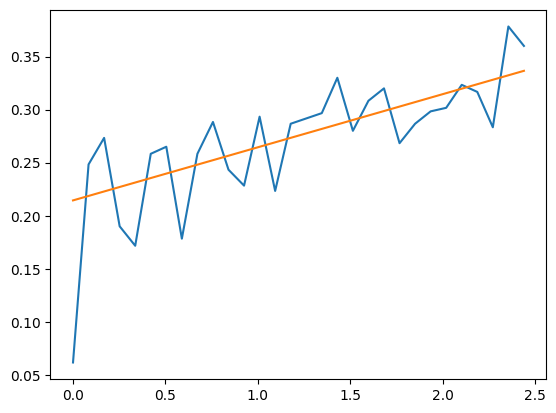

In [7]:
#Generate dense theta simulation data:  from detune scanning




#Simulating the Jij XX oscillations with active heating + maybe dephasing noise
"""How to deal with active heating of the chain?
Option 1: increase the random theta linearly in time. Probably the best bet. 
Option 2: rescample ever few time steps with a higher temperature.

I think option 1 is the best for now
"""
#Need to set Jij ~1000*2*pi, so Omega = np.sqrt(1000). This way the time scale is ms for a full Jij oscillation
#Realistic:
#theta_0  = 0.060577043438396795
#theta_dot = 0.0502438865537055 * 1e3
#print(theta_0)
#print(theta_dot)
#Not realistic:
theta_0  = 0.0528
#theta_0 = 0
theta_dot = 0.024# * 1e3
#theta_dot = 0.124# * 1e3

print(times)
theta_f = theta_0 + theta_dot*max(times)#/1e3
print(theta_f)

#theta_0 = 0
#theta_dot = 0
sx, sy, sz = get_s_lists(2)

#t_list = np.linspace(0, max(times), 200)# * 1e-3
t_list = times
psi0 = tensor(basis(2,0), basis(2,1))
rho0 = psi0*psi0.dag()
ket00 = tensor(basis(2,0), basis(2,0))
ket01 = tensor(basis(2,0), basis(2,1))
ket10 = tensor(basis(2,1), basis(2,0))
ket11 = tensor(basis(2,1), basis(2,1))

rho00_00 = ket00*ket00.dag()
rho00_01 = ket00*ket01.dag()
rho01_00 = ket01*ket00.dag()

rho11_11 = ket11*ket11.dag()
rho11_01 = ket11*ket01.dag()
rho01_11 = ket01*ket11.dag()



#ket10_00 = 
rho_x0 = lambda p: p*rho00_00 - p*rho0
rho_x1 = lambda p: p*rho11_11 - p*rho0


def J_func(J,i,j):
    return J*np.exp(-1*abs(i-j)+1)

def genH(theta_0, J, B):
    delta = thermal_rejection(theta_0,1)[0]
    factor = (1 - delta)**2
    #HXX = sx[0]*0
    #for i in range(2):
    #    for j in range(i+1,2):
    #        HXX += J_func(J,i,j)*factor*(sx[i]*sx[j])
    HXX = J*sx[0]*sx[1]*factor
    
    #HXX = sum([ sum( [J(i,j)*factor*(sx[i]*sx[j]) of i in range(j+1,4)] for j in range(4)]))

    #HXX = J*factor*(sx[0]*sx[1]) 
    #print(HXX)
    HB = B*(sz[0] + sz[1])# + sz[2] + sz[3])
    #print(HB)

    return [HXX + HB]

def genHt(theta_0, theta_dot, J, B):
    delta = thermal_rejection(theta_0,1)[0]
    def delta_func(t, args):
        updated_delta = delta + theta_dot*t#*10
        #print(t, updated_delta)
        return J*(1- updated_delta)**2

    HXX = sx[0]*sx[1]#*factor

    HB = B*(sz[0] + sz[1])# + sz[2] + sz[3])
    return [[HXX,delta_func]]
    


#psi0 = tensor(basis(2,0), basis(2,0))
#yplus = (basis(2,0) + 1j*basis(2,1)).unit()
#minus = 
#psi0 = tensor(yplus, yplus)

#import Options from qutip:
from qutip.solver import Options
#increase nsteps
options = Options(nsteps=1e3)

def run(J,B, obs = None, noise={}, time = t_list):
    xrate = 0
    zrate = 0
    theta_0 = 0
    SPAM = 0
    try:
        xrate = noise['x']
    except:
        pass
    try:
        zrate = noise['z']
    except:
        pass
    try:
        theta_0 = noise['theta']
    except:
        pass
    try: 
        SPAM = noise['SPAM']
    except:
        pass
    #print(xrate)
    #print(zrate)
    #print(theta_0)
    #H = genH(theta_0,J,B)
    Ht = genHt(theta_0, theta_dot, J, B)
    noisy_ops = [sx[i]*xrate for i in range(2)]
    #noisy_ops = [sx[0]*xrate]
    #Sz_noise = (sz[0] * sz[1])*zrate#*sx[2]*sz[3])*zrate
    Sz_noise = [sz[i]*zrate for i in range(2)]
    #noisy_ops = []
    noisy_ops.append(Sz_noise)
    rho0 = psi0*psi0.dag()
    if SPAM > 0:
        rho0 += rho_x0(SPAM/2)
        rho0 += rho_x1(SPAM/2)
    #results = mesolve(H, psi0,time, noisy_ops, obs, options=options)#, ntraj=1)
    results = mesolve(Ht, rho0,time, noisy_ops, obs, options=options)#, ntraj=1)
    return results
sim_shots = 600
#


#full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, theta_dot,Omega) for i in range(shots))
    

def gen_full_results(J,B, obs=None, noise={}, time=t_list, shot_noise = False):
    #H = genH(theta_0, theta_dot)
    #run(theta_0, J,B)
    #print(noise)
    #full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, J,B,obs = obs, noise=noise, time=time) for _ in range(shots))
    #full_results = np.array([run(J,B,obs = obs, noise=noise, time=time) for _ in range(sim_shots)])
    full_results = Parallel(n_jobs=6)(delayed(run)(J,B,obs = obs, noise=noise, time=time) for _ in range(sim_shots))
    
    averaged = np.zeros(len(time))
    for item in full_results:
        #print(item.expect[0])
        averaged += sum(item.expect)
    averaged = averaged/sim_shots
    if shot_noise:    
        return averaged + np.random.normal(0, 1/np.sqrt(sim_shots), len(time))
    else:
        return averaged
#fit leakage matrix to a line:
def linear(x, m, c):
    return m*x + c
popt, pcov = curve_fit(linear, times[1:], leakage_matrix[1:,0])
print(popt)
intercept = 1-popt[1]
slope = popt[0]
plt.plot(times, leakage_matrix[:,0])
plt.plot(times, linear(times, *popt))

def exp_fit(x, a, b, c):
    return a * np.exp(-b * x) + c

#popt, pcov = curve_fit(exp_fit, times[1:], leakage_matrix[1:,0], p0=[1, .05, -1])
#popt, pcov = curve_fit(exp_fit, times, leakage_matrix[:,0], p0=[1, -.04, -0.95])

#print(popt)
#plt.plot(times, leakage_matrix[:,0])
#plt.plot(times, exp_fit(times, *popt))


In [8]:
# plt.plot(times, flopping_matrix[:,0])
# plt.plot(times, np.cos(2*J*times))
# plt.show()

0
0.21442118227713003
0.78557881772287


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


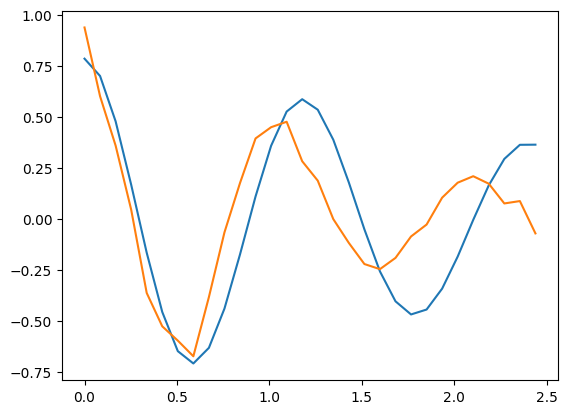

0.78557881772287


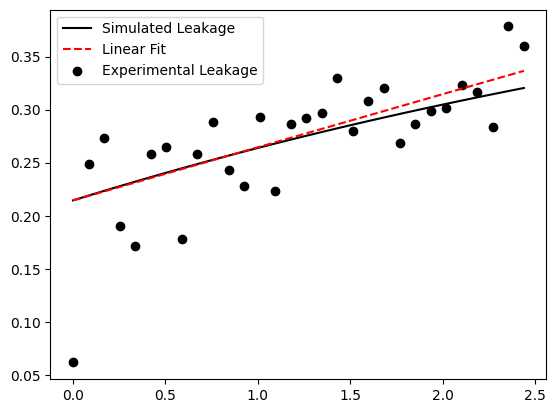

In [9]:
dense_theta = np.linspace(0, 0.16,30)
from scipy.special import lambertw
#J should be the oscilaltion frequency, NOT match the data
#J = Omega[0]/2#/0.85


#1.05*np.pi#*0.95/2
B = 0#0.4*J
#leakage_obs = [sz[0]*sz[1]]#
zeroZero = tensor(basis(2,0), basis(2,0))
oneOne = tensor(basis(2,1), basis(2,1))
zeroRho = zeroZero*zeroZero.dag()
oneRho = oneOne*oneOne.dag()
leakage_obs = [zeroRho, oneRho]#
oscillation_obs = [sz[0]/2, -1*sz[1]/2]
#print(np.sqrt(0.0015)*J)
middle = 0#np.mean(leakage_matrix[:,0])
print(middle)
print(1-intercept)
#alpha = 
#alpha = -1*(lambertw(-2*np.exp(middle*(1-intercept))*slope*(1-intercept)))/(1-intercept)
alpha = -lambertw(-2*slope/(2*intercept-1))

#-lambertw(-2*slope*(1-intercept))/(1-intercept)
noise_dict = {'x':alpha, 'z':0, 'theta':theta_0, 'SPAM': (1-intercept)}
print(intercept)

results_Jij_oscillation = gen_full_results(J, B, obs=oscillation_obs, noise=noise_dict, shot_noise=False)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
results_Jij_leakage = gen_full_results( J, B, obs=leakage_obs, noise=noise_dict, shot_noise=False)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
#Check if dense_theta_oscillations is defined. If not, define it
plt.plot(times, results_Jij_oscillation)
plt.plot(times, flopping_matrix[:,0])
plt.show()
print(intercept)
plt.plot(times, results_Jij_leakage, label = 'Simulated Leakage', color = 'k')
plt.plot(times, linear(times, slope, -1*intercept+1), color = 'r', linestyle = '--', label="Linear Fit")
#plt.plot(times, exp_fit(times, *popt), color = 'orange', linestyle = '--', label="Exponential Fit")
plt.scatter(times, leakage_matrix[:,0], label = 'Experimental Leakage', color = 'k')
plt.legend()
plt.show()


0.9475965475678084
1.815849853957559


/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


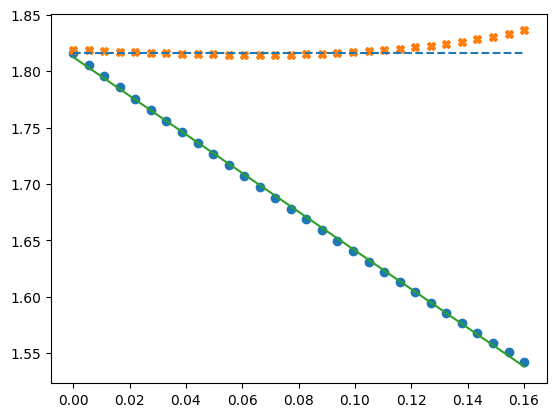

[1.72373847 1.73278258 1.7419221  1.75115854 1.76049345 1.76992842
 1.77946507 1.78910504 1.79885003 1.80870175 1.81866198 1.82873252
 1.8389152  1.84921192 1.8596246  1.8701552  1.88080575 1.89157831
 1.90247498 1.91349791 1.92464933 1.93593148 1.94734669 1.95889731
 1.97058577 1.98241456 1.99438622 2.00650334 2.0187686  2.03118474]


In [10]:
zero_temp_Omega_value = zero_temperature_Omega(theta_0, np.sqrt(J), times)
effective_frequency_shift = np.sqrt(J)/zero_temp_Omega_value
print(effective_frequency_shift)
print(zero_temp_Omega_value)
Omega_comps = calibrate_sim_Omegas(dense_theta, zero_temp_Omega_value, times, debug=True)*np.sqrt(J)

print(Omega_comps)
J_calibrated = J#Omega_comps**2



#try:
#    dense_theta_oscillations
#except:
dense_theta_oscillations = []
dense_theta_leakage = []
for theta_index in range(len(dense_theta)):
    theta = dense_theta[theta_index]
    J_calibrated = Omega_comps[theta_index]**2
    #J_calibrated = dense_J_cal[theta_index]
#for theta_point in dense_theta:
    noise_dict['theta'] = theta#{'x':np.sqrt(slope), 'z':0, 'theta':theta_point}
    dense_theta_oscillations.append(gen_full_results(J_calibrated, B, obs=oscillation_obs, noise=noise_dict, shot_noise=False))
    dense_theta_leakage.append(gen_full_results(J_calibrated, B, obs=leakage_obs, noise=noise_dict, shot_noise=False))



In [11]:
#Generates the zero leakage results at the baseline temp -- simulates maximum possible recovery from pure PS
noise_dict_zero_x = {'x':0, 'z':0, 'theta':theta_0}
baseline_index = np.argmin(np.abs(dense_theta - theta_0))
#!!!!!!!!!!!!!!!!
calibration_J = Omega_comps[baseline_index]**2
#calibration_J = dense_J_cal[baseline_index]
zero_leakage_oscillations = gen_full_results(calibration_J, B, obs=oscillation_obs, noise=noise_dict_zero_x)


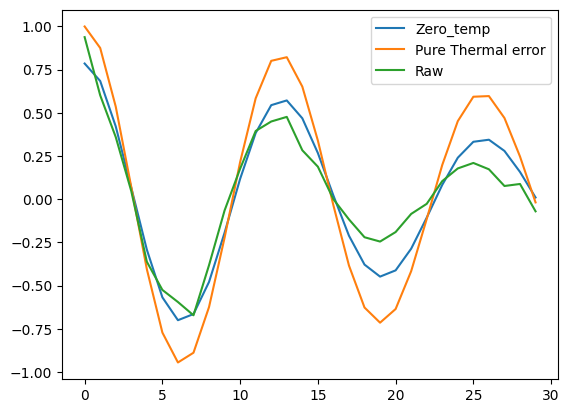

In [12]:
PS_zero_temperature = dense_theta_oscillations[baseline_index]/(1-dense_theta_leakage[baseline_index])
plt.plot(dense_theta_oscillations[baseline_index], label='Zero_temp')
plt.plot(zero_leakage_oscillations, label='Pure Thermal error')
#plt.scatter(range(len(flopping_matrix[:,0])),flopping_matrix[:,0]/(1-dense_theta_leakage[baseline_index]), label='PS experimental vs sim')
plt.plot(range(len(flopping_matrix[:,0])),flopping_matrix[:,0], label='Raw')
#plt.plot(range(len(flopping_matrix[:,0])),flopping_ps_smoothed[:,0], label='PS smoothed')
plt.legend()

In [13]:
zero_temp_Omega_value = zero_temperature_Omega(theta_0, np.sqrt(J), times)
effective_frequency_shift = np.sqrt(J)/zero_temp_Omega_value
print(effective_frequency_shift)
print(np.sqrt(J))
Omega_comps = calibrate_sim_Omegas(theta_list, zero_temp_Omega_value, times, debug=False)*np.sqrt(J)
print(Omega_comps - 1.46*theta_list)
print(Omega_comps)

# for theta_index in range(len(theta_list)):
#     theta_temp = theta_list[theta_index]
#     noise_dict['theta'] = theta_temp

#     results_Jij_oscillation = gen_full_results(Omega_comps[theta_index]**2, B, obs=oscillation_obs, noise=noise_dict)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
#     results_Jij_leakage = gen_full_results( Omega_comps[theta_index]**2, B, obs=leakage_obs, noise=noise_dict)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
#     #Check if dense_theta_oscillations is defined. If not, define it
#     plt.plot(times, results_Jij_oscillation)
#     plt.plot(times, flopping_matrix[:,theta_index])
#     plt.show()


0.9475965475678084
1.720693052511692
[1.74371476 1.7452379  1.74861507 1.75453589 1.75907587 1.76410908
 1.77896512 1.79730585 1.84579913]
[1.82655109 1.83653248 1.85682625 1.88812184 1.90957841 1.93152813
 1.98867553 2.04930762 2.18238361]


In [14]:
zero_temp_Omega_value = zero_temperature_Omega(theta_0, np.sqrt(J), times)
effective_frequency_shift = np.sqrt(J)/zero_temp_Omega_value
print(effective_frequency_shift)
print(np.sqrt(J))
Omega_comps = calibrate_sim_Omegas(dense_theta, zero_temp_Omega_value, times, debug=False)*np.sqrt(J)

print('Shifted')
print(dense_theta)
print((Omega_comps - 1.46*dense_theta)**2)
print(J)



#for Omega_comp in Omega_comps:
#    calibrate_sim_Omegas(dense_theta, Omega_comp, times, debug=True)

print(Omega_comps)
print(zero_temp_Omega_value)
#print(Omega_comps)
#print(dense_theta)

0.9475965475678084
1.720693052511692
Shifted
[0.         0.00551724 0.01103448 0.01655172 0.02206897 0.02758621
 0.03310345 0.03862069 0.04413793 0.04965517 0.05517241 0.06068966
 0.0662069  0.07172414 0.07724138 0.08275862 0.08827586 0.0937931
 0.09931034 0.10482759 0.11034483 0.11586207 0.12137931 0.12689655
 0.13241379 0.13793103 0.14344828 0.14896552 0.15448276 0.16      ]
[2.97127432 2.97468464 2.97842621 2.9825049  2.98692675 2.99169798
 2.99682504 3.00231455 3.00817335 3.0144085  3.02102727 3.02803718
 3.03544598 3.04326169 3.05149255 3.06014711 3.06923418 3.07876285
 3.08874253 3.09918293 3.11009408 3.12148635 3.13337046 3.1457575
 3.15865892 3.17208657 3.18605269 3.20056997 3.21565151 3.23131089]
2.960784580962004
[1.72373847 1.73278258 1.7419221  1.75115854 1.76049345 1.76992842
 1.77946507 1.78910504 1.79885003 1.80870175 1.81866198 1.82873252
 1.8389152  1.84921192 1.8596246  1.8701552  1.88080575 1.89157831
 1.90247498 1.91349791 1.92464933 1.93593148 1.94734669 1.95889731

In [15]:
#Plotting the ZNE Data slice:
#Add a vertial slice at the 3rd peak:
index = 12
dense_theta_oscillations_array = np.array(dense_theta_oscillations)
dense_theta_leakage_array = np.array(dense_theta_leakage)

dense_flopping = ZNE_funcs_ps[index](dense_theta)
dense_ZNE_no_ps = ZNE_funcs[index](dense_theta)


In [16]:
errors_basic = np.abs((np.cos(Omega[0]*times) - flopping_matrix[:,0])/np.cos(Omega[0]*times))
errors_ZNE = np.abs((np.cos(Omega[0]*times) - ZNE_data_smooth)/np.cos(Omega[0]*times))
errors_PS_ZNE = np.abs((np.cos(Omega[0]*times) - ZNE_data_smooth_ps)/np.cos(Omega[0]*times))
errors_PS_only = np.abs((np.cos(Omega[0]*times) - flopping_ps_smoothed[:,0])/np.cos(Omega[0]*times))
#Smooth all the errors by convolving with a gaussian:
window = 10



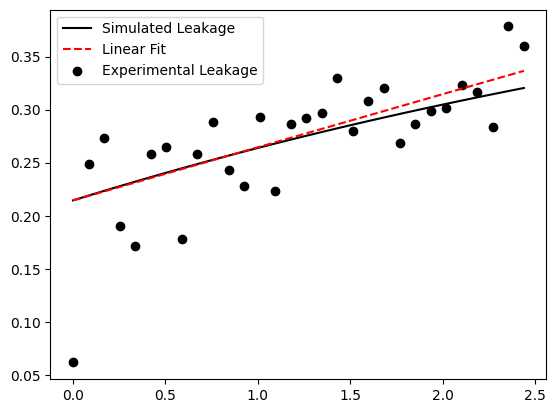

In [17]:
#plot the leakage of the simulation and the experimental data
#plt.plot(times, 1+results_Jij_leakage*intercept, label = 'Leakage', color = 'r')
#dense_t
plt.plot(times, dense_theta_leakage_array[baseline_index], label = 'Simulated Leakage', color = 'k')
#Generate a bist fit line of the leakage matrix, not including the t=0 point:
#cureve fit:
#popt, pcov = curve_fit(linear, times[1:], leakage_matrix[1:,0])
#print(popt)
plt.plot(times, linear(times, slope, -1*intercept+1), color = 'r', linestyle = '--', label="Linear Fit")

#plt.plot(times, exp_fit(times, *popt), color = 'orange', linestyle = '--', label="Exponential Fit")

#plt.fill_between(times, 1+results_Jij_leakage*intercept-1/np.sqrt(shots), 1+results_Jij_leakage*intercept+1/np.sqrt(shots), color = 'blue', alpha = 0.2)
plt.scatter(times, leakage_matrix[:,0], label = 'Experimental Leakage', color = 'k')
plt.legend()

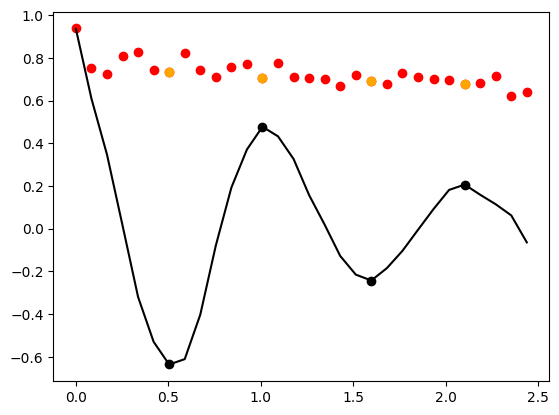

In [18]:
#Get the peak indices:
peak_indices = np.where(np.diff(np.sign(np.diff(np.abs(flopping_matrix_smooth[:,0])))) == -2)[0]+1

plt.plot(times[peak_indices], flopping_matrix_smooth[peak_indices,0], 'o', color = 'k')
plt.plot(times, flopping_matrix_smooth[:,0], label = 'Experimental Flopping', color = 'k')
plt.scatter(times, 1-leakage_matrix[:,0], label = '1-Leakage', color = 'r')
plt.scatter(times[peak_indices], 1-leakage_matrix[peak_indices,0], label = '1-Leakage', color = 'orange')


[5.9287207  5.88796095 6.04698447 6.12402098 6.22688549 6.2692228
 6.30249869 6.29373186 6.27859806]
5.928720696492862
5.921569161924008
0.78557881772287


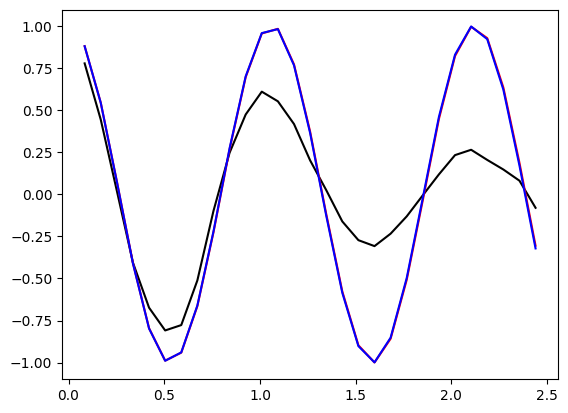

In [19]:
plt.plot(times[1:], flopping_matrix_smooth[1:,0]/intercept, label = 'Experimental Flopping', color = 'k')
plt.plot(times[1:], np.cos(J*2*times[1:]), label = 'Ideal', color = 'r')
print(Omega)
J_Omega = Omega[0]
print(J_Omega)
print(J*2)
print(intercept)
plt.plot(times[1:], np.cos(J_Omega*times[1:]), label = 'Ideal', color = 'b')


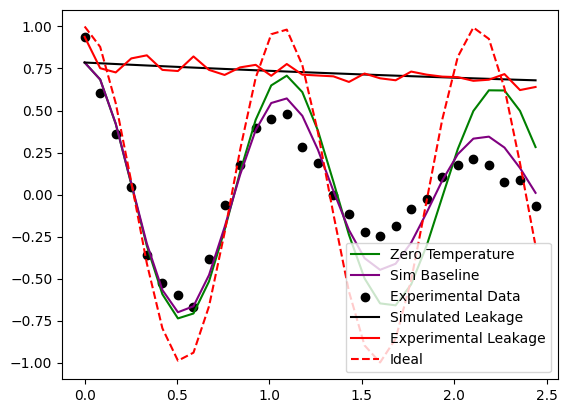

In [20]:

#Plot the oscillations:
#print(results_Jij_oscillation.shape)
#print(intercept)
#print(dense_theta_oscillations_array[0])

## Plots the zero temperature limit of the simulation data, which includes SPAM and depolarizing noise
plt.plot(times, dense_theta_oscillations_array[0], label = 'Zero Temperature', color = 'g')
#print(dense_theta)
baseline_index = np.argmin(np.abs(dense_theta - theta_0))
#print(baseline_index)
#baseline_index = 2


#Plots the baseline experimental emulation data. This has a frequency correction applied to match the experimental data
plt.plot(times, dense_theta_oscillations_array[baseline_index], label = 'Sim Baseline', color = 'purple')

#Plots the experimental data (smoothed)
plt.scatter(times, flopping_matrix[:,0], label = 'Experimental Data', color = 'k')
#plt.scatter(times, flopping_matrix_smooth[:,-1], label = 'Experimental Data High temp', color = 'k')

plt.plot(times, 1-dense_theta_leakage_array[baseline_index], label = 'Simulated Leakage', color = 'k')
plt.plot(times, 1-leakage_matrix[:,0], label = 'Experimental Leakage', color = 'r')
#Plots the Ideal oscillations

plt.plot(times, np.cos(J*2*times), label = 'Ideal', color = 'r', linestyle = '--')

#Plotting the ZNE results, for PS and without PS. The PS has to be before the ZNE. Also smoothing the ZNE results
#plt.plot(times, ZNE_data_smooth, label = 'ZNE', color = 'b')
#plt.plot(times, ZNE_data_smooth_ps, label = 'ZNE + PS', color = 'orange')



plt.legend()

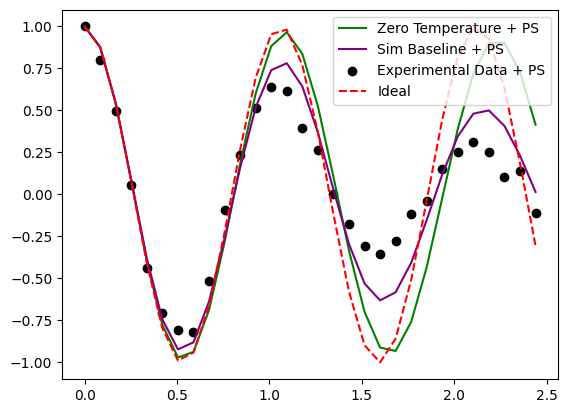

In [21]:

#Plot the oscillations:
#print(results_Jij_oscillation.shape)
#print(intercept)
#print(dense_theta_oscillations_array[0])

## Plots the zero temperature limit of the simulation data, which includes SPAM and depolarizing noise
plt.plot(times, dense_theta_oscillations_array[0]/(1-dense_theta_leakage_array[0]), label = 'Zero Temperature + PS', color = 'g')
#print(dense_theta)
baseline_index = np.argmin(np.abs(dense_theta - theta_0))
#print(baseline_index)
#baseline_index = 2


#Plots the baseline experimental emulation data. This has a frequency correction applied to match the experimental data
plt.plot(times, dense_theta_oscillations_array[baseline_index]/(1-dense_theta_leakage_array[baseline_index]), label = 'Sim Baseline + PS', color = 'purple')

#Plots the experimental data (smoothed)
plt.scatter(times, flopping_matrix[:,0]/(1-leakage_matrix[:,0]), label = 'Experimental Data + PS', color = 'k')
#plt.scatter(times, flopping_matrix_smooth[:,-1], label = 'Experimental Data High temp', color = 'k')

#plt.plot(times, 1-dense_theta_leakage_array[baseline_index], label = 'Simulated Leakage', color = 'k')
#plt.plot(times, 1-leakage_matrix[:,0], label = 'Experimental Leakage', color = 'r')
#Plots the Ideal oscillations

plt.plot(times, np.cos(J*2*times), label = 'Ideal', color = 'r', linestyle = '--')
plt.ylim(-1.1, 1.1)

#Plotting the ZNE results, for PS and without PS. The PS has to be before the ZNE. Also smoothing the ZNE results
#plt.plot(times, ZNE_data_smooth, label = 'ZNE', color = 'b')
#plt.plot(times, ZNE_data_smooth_ps, label = 'ZNE + PS', color = 'orange')



plt.legend()

10


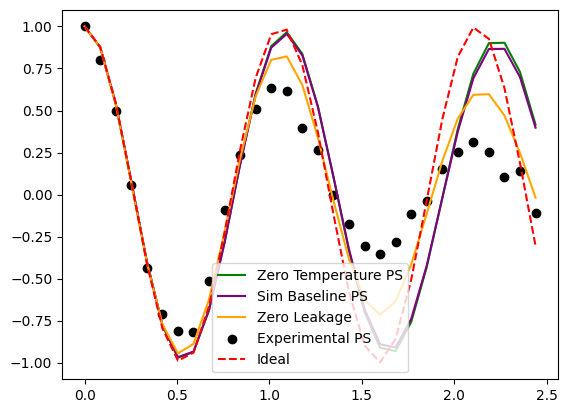

In [22]:

#Plot the oscillations:
#print(results_Jij_oscillation.shape)
#print(intercept)
#print(dense_theta_oscillations_array[0])

## Plots the zero temperature limit of the simulation data, which includes SPAM and depolarizing noise
plt.plot(times, dense_theta_oscillations_array[0]/(1-dense_theta_leakage_array[0]), label = 'Zero Temperature PS', color = 'g')
#print(dense_theta)
baseline_index = np.argmin(np.abs(dense_theta - theta_0))
print(baseline_index)
baseline_index = 2


#Plots the baseline experimental emulation data. This has a frequency correction applied to match the experimental data
plt.plot(times, dense_theta_oscillations_array[baseline_index]/(1-dense_theta_leakage_array[baseline_index]), label = 'Sim Baseline PS', color = 'purple')
plt.plot(times, zero_leakage_oscillations, label = 'Zero Leakage', color = 'orange')
#Plots the experimental data (smoothed)
plt.scatter(times, flopping_matrix[:,0]/(1-leakage_matrix[:,0]), label = 'Experimental PS', color = 'k')
#plt.scatter(times, flopping_matrix_smooth[:,-1], label = 'Experimental Data High temp', color = 'k')

#Plots the Ideal oscillations
plt.plot(times, np.cos(J*2*times), label = 'Ideal', color = 'r', linestyle = '--')

#Plotting the ZNE results, for PS and without PS. The PS has to be before the ZNE. Also smoothing the ZNE results
#plt.plot(times, ZNE_data_smooth, label = 'ZNE', color = 'b')
#plt.plot(times, ZNE_data_smooth_ps, label = 'ZNE + PS', color = 'orange')



plt.legend()

2


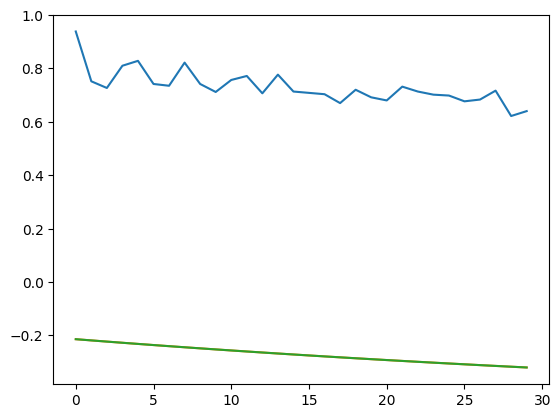

In [23]:
plt.plot(1-leakage_matrix[:,0])
plt.plot(-dense_theta_leakage_array[baseline_index])
print(baseline_index)
plt.plot(-dense_theta_leakage_array[0])

[0.05673721 0.06253054 0.07411725 0.09149722 0.10308393 0.11467058
 0.14363726 0.17260395 0.23053732]
[10, 11, 13, 17, 19, 21, 26, 29, 29]
Numerical Frequencies relative to baseline
[ 1.         -1.00666229 -1.02128444 -1.06117417 -1.07276942  1.0936874
  1.15995244 -1.18400698 -1.18400698]
Experimental frequencies relative to baseline
[1.         0.99400182 1.0227693  1.03886743 1.05498897 1.0615045
 1.06992299 1.08530615 1.08501614]
2.960784580962004
2.960784580962004
Numerical value of theta*Omega
[0.3599545855156158, -0.39255629733364833, 0.4223988897468461, 0.49013119170747416, -0.6060463468130559, -0.6057670668841009, 0.7468517829060951, 0.8385571829842651, 0.8385571829842651]
Experimental value of theta*Omega
[0.33597333 0.37027891 0.43889041 0.54180713 0.61041863 0.67902978
 0.850558   1.02208622 1.36514266]


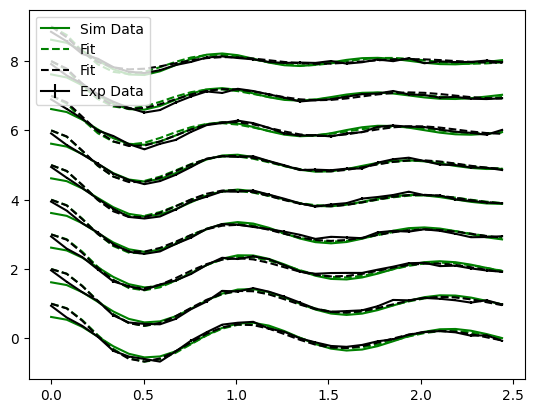

In [24]:
"""In a single plot, plot each of the sub_indexed data points corresponding to the temperatures, offset vertically. For each value of theta, find the matching index in the dense_thetas list, and plot the matching simulation over top. 

"""
#theta_sub_index = [0,2,3]
print(theta_list)
matching_theta_indices = [np.argmin(np.abs(dense_theta - theta_list[i])) for i in theta_sub_index]
print(matching_theta_indices)
for i in range(len(theta_sub_index)):
    offset = 1*i
    if i == 0:
        
        plt.plot(times, dense_theta_oscillations_array[matching_theta_indices[i]]*intercept+offset, label = 'Sim Data', color = 'g')
        plt.errorbar(times, flopping_matrix[:,theta_sub_index[i]] + offset, label = 'Exp Data', color = 'k', yerr=1/np.sqrt(shots)*flopping_std_matrix[:,theta_sub_index[i]])
    else:
        plt.plot(times, dense_theta_oscillations_array[matching_theta_indices[i]]*intercept+offset, color = 'g')
        plt.errorbar(times, flopping_matrix[:,theta_sub_index[i]] + offset, color = 'k', yerr=1/np.sqrt(shots)*flopping_std_matrix[:,theta_sub_index[i]])
    
    
#Make the plot much taller vertically

#For each, extract the frequency of the green and black curves by fitting to the cetina envelope function.cetina_envelope_exp
numerical_frequencies = []
experimental_frequencies = []
numerical_theta = []
for i in range(len(theta_sub_index)):
    #fit the simulation data:
    offset = 1*i
    popt, pcov = curve_fit(cetina_envelope_exp, times, dense_theta_oscillations_array[matching_theta_indices[i]]*intercept, p0=[np.sqrt(J), .05])
    numerical_frequencies.append(popt[1])
    numerical_theta.append(popt[0])
    if i==0:
        plt.plot(times, cetina_envelope_exp(times, *popt)+offset, color = 'g', linestyle = '--', label='Fit')
    else:
        plt.plot(times, cetina_envelope_exp(times, *popt)+offset, color = 'g', linestyle = '--')

    popt, pcov = curve_fit(cetina_envelope_exp, times, flopping_matrix[:,theta_sub_index[i]], p0=[np.sqrt(J), 0.05])
    experimental_frequencies.append(popt[1])
    
    if i==0:
        plt.plot(times, cetina_envelope_exp(times, *popt)+offset, color = 'k', linestyle = '--', label='Fit')
    else:
        plt.plot(times, cetina_envelope_exp(times, *popt)+offset, color = 'k', linestyle = '--')
plt.legend()
print('Numerical Frequencies relative to baseline')
print(numerical_frequencies/numerical_frequencies[0])
print('Experimental frequencies relative to baseline')
print(experimental_frequencies/experimental_frequencies[0])
print(J)
#J = -1*experimental_frequencies[0]/2
print(J)
print('Numerical value of theta*Omega')
print(numerical_theta)
print('Experimental value of theta*Omega')
print(theta_list[theta_sub_index]*J*2)

In [25]:
print(times)
print(np.sqrt(J))

[0.         0.08413281 0.16826563 0.25239844 0.33653125 0.42066406
 0.50479688 0.58892969 0.6730625  0.75719531 0.84132812 0.92546094
 1.00959375 1.09372656 1.17785937 1.26199219 1.346125   1.43025781
 1.51439063 1.59852344 1.68265625 1.76678906 1.85092188 1.93505469
 2.0191875  2.10332031 2.18745313 2.27158594 2.35571875 2.43985156]
1.720693052511692


0 is good
1 is bad -- frequency shift (high)
2 is not very nice up to loss
3 is pretty good
4 and 5 are bad -- wrong frequency

So, need to redo:
1, 4, and 5. Maybe 2
[0,2,3]

[0.05673721 0.06253054 0.07411725 0.09149722 0.10308393 0.11467058
 0.14363726 0.17260395 0.23053732]
[10, 11, 13, 17, 19, 21, 26, 29, 29]


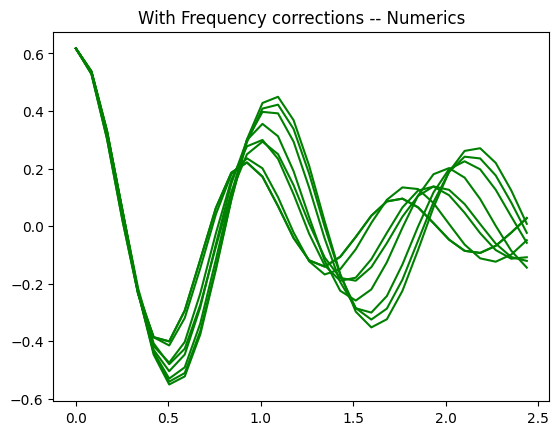

In [26]:
"""In a single plot, plot each of the sub_indexed data points corresponding to the temperatures, offset vertically. For each value of theta, find the matching index in the dense_thetas list, and plot the matching simulation over top. 

"""
#theta_sub_index = [0,2,3]
print(theta_list)
matching_theta_indices = [np.argmin(np.abs(dense_theta - theta_list[i])) for i in theta_sub_index]
print(matching_theta_indices)
for i in range(len(theta_sub_index)):
    offset = 2*i
    plt.title('With Frequency corrections -- Numerics')
    plt.plot(times, dense_theta_oscillations_array[matching_theta_indices[i]]*intercept, label = 'Sim Data', color = 'g')
    #plt.scatter(times, flopping_matrix_smooth[:,theta_sub_index[i]] + offset, label = 'Exp Data', color = 'k')
    

[10, 11, 13, 17, 19, 21, 26, 29, 29]


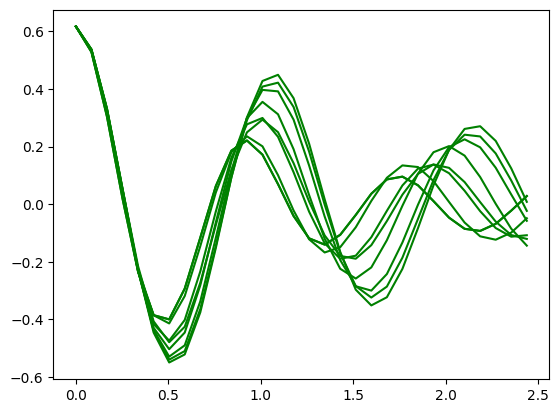

In [27]:
"""In a single plot, plot each of the sub_indexed data points corresponding to the temperatures, offset vertically. For each value of theta, find the matching index in the dense_thetas list, and plot the matching simulation over top. 

"""

matching_theta_indices = [np.argmin(np.abs(dense_theta - theta_list[i])) for i in theta_sub_index]
print(matching_theta_indices)
for i in range(len(theta_sub_index)):
    offset = 0
    plt.plot(times, dense_theta_oscillations_array[matching_theta_indices[i]]*intercept , label = 'Sim Data', color = 'g')
    #plt.plot(times, flopping_matrix_smooth[:,theta_sub_index[i]] + offset, label = 'Exp Data', color = 'k')
    

0.02206896551724138


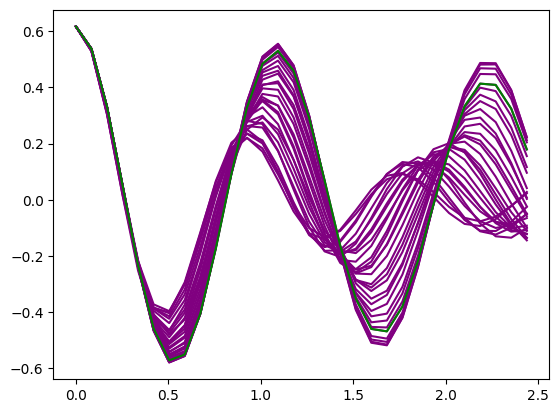

In [28]:
for theta_index in range(len(dense_theta)):
    plt.plot(times, dense_theta_oscillations_array[theta_index]*intercept, color = 'purple')
print(dense_theta[4])
plt.plot(times, dense_theta_oscillations_array[4]*intercept, label = 'Zero Temperature', color = 'g')

In [29]:
# def fit_function(t, theta, Omega):
#         """The full Cetina function for the single COM mode
#         shots
        
#         Args:
#         t: float, time
#         theta: float, the shift of the gaussian envelope
#         Omega: float, the frequency of the gaussian envelope
        
#         Returns:
#         float: the value of the function at time t
#         """
#         #It's just an envelope of the expected form and a constant Cos function
#         C = 1/np.sqrt((1 + (Omega*theta*t)**2))
#         return  C * np.cos(2*Omega*t)
    
# def generate_fake_data(times, J_value, theta):
#     averages = 100
#     output_expectations = np.zeros(len(times))
#     for _ in range(averages):  
#         theta_sample = thermal_rejection(theta, 1)[0]     
#         output_expectations += np.cos(2*J_value*((1-theta_sample)**2)*times)
#     return output_expectations/averages
# J_target = J
# #The cost function takes in the value of x we want to optimize over, adn also the argument for theta to pass ot the fake data
# def cost_function(J_test, *args):
#     theta = args[0]
#     times = args[1]
#     #print('Running')
#     get_Y_data_for_J = generate_fake_data(times, J_test, theta)
#     #print('Generated Data')
#     #Get the frequency of the fake data for that J
#     #print(type(J_test[0]))
#     popt, pcov = curve_fit(fit_function, times, get_Y_data_for_J, p0=[0.05, J_test[0]])
#     #print('Fitted curve')
#     #The cost function is the value of the observed Omega vs. the target value which is J
#     #print(popt)
#     return np.abs(popt[1]-J_target)

# test_data = generate_fake_data(times, J, 0.05)
# plt.plot(times, test_data)
# popt = curve_fit(fit_function, times, test_data, p0=[0.05, J])[0]

# plt.plot(times, fit_function(times, *popt))

# #print(cost_function(J, 0.05))
# minimize(cost_function, J, args=(0.05, times))
# plt.plot(times, generate_fake_data(times, J, 0.05))

2.960784580962004


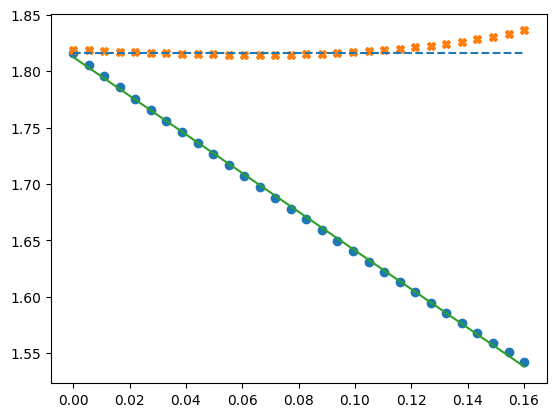

Normal Calibration
[1.72373847 1.73278258 1.7419221  1.75115854 1.76049345 1.76992842
 1.77946507 1.78910504 1.79885003 1.80870175 1.81866198 1.82873252
 1.8389152  1.84921192 1.8596246  1.8701552  1.88080575 1.89157831
 1.90247498 1.91349791 1.92464933 1.93593148 1.94734669 1.95889731
 1.97058577 1.98241456 1.99438622 2.00650334 2.0187686  2.03118474]
2.960784580962004
(30,)
(30, 30)
0
10
20


In [30]:
from scipy.optimize import minimize
def calibrate_Js(J_target, thetas, times, debug=False):
    """Returns a calibrated list of Js matching the input of thetas such that the fit of the frequency over the time scale is equal to J

    Args:
        J (float): Target value of J
        thetas (array: float): values of theta to calibrate over
        times (array: float): times to optimize over
        debug(bool): whether to plot the results
    """
    #This is the function that we want to fit to fake data -- It extracts a fixed Omega value
    def fit_function(t, theta, Omega):
        """The full Cetina function for the single COM mode
        shots
        
        Args:
        t: float, time
        theta: float, the shift of the gaussian envelope
        Omega: float, the frequency of the gaussian envelope
        
        Returns:
        float: the value of the function at time t
        """
        #It's just an envelope of the expected form and a constant Cos function
        C = 1/np.sqrt((1 + (Omega*theta*t)**2))
        return  C * np.cos(2*Omega*t)
    
    #This generates the fake Jij data by averaging over 100 thermal samples
    def generate_fake_data(times, J_value, theta):
        averages = 10000
        output_expectations = np.zeros(len(times))
        for _ in range(averages):  
            theta_sample = thermal_rejection(theta, 1)[0]     
            output_expectations += np.cos(2*J_value*((1-theta_sample)**2)*times)
        return output_expectations/averages
    #The cost function takes in the value of x we want to optimize over, adn also the argument for theta to pass ot the fake data
    def cost_function(J_test, theta):
        get_Y_data_for_J = generate_fake_data(times, J_test, theta)
        #Get the frequency of the fake data for that J
        popt, pcov = curve_fit(fit_function, times, get_Y_data_for_J, p0=[0.05, J_test[0]])
        #The cost function is the value of the observed Omega vs. the target value which is J
        return np.abs(popt[1]-J_target)
    
        
    output_Js = np.zeros(len(thetas))
    for i, theta in enumerate(thetas):
        result = minimize(cost_function, J_target, args=(theta), method='Powell', options={'maxiter':1000})
        output_Js[i] = result.x[0]
        if debug:
            try:
                popt, pcov = curve_fit(linear, thetas, output_Js)
            except Exception as e:
                #print(e)
                print(output_Js)
                popt = (0,J_target)
            plt.plot(thetas, linear(thetas, *popt))
            plt.plot(thetas, output_Js, 'o')
            plt.show()
            plt.plot(times, generate_fake_data(times, output_Js[i], thetas[i]))
            popt, pcov = curve_fit(fit_function, times, generate_fake_data(times, output_Js[i], thetas[i]), p0=[0.05, output_Js[0]])
            plt.plot(times, fit_function(times, *popt))
            plt.plot(times, np.cos(2*J_target*times))
            plt.show()
        
    #Fit thetas vs. output_Js to a line:
    popt, pcov = curve_fit(linear, thetas, output_Js)
    if debug:
        plt.plot(thetas, linear(thetas, *popt))
        plt.plot(thetas, output_Js, 'o')
        plt.show()
        plt.plot(times, generate_fake_data(times, output_Js[-1], thetas[-1]))
        popt, pcov = curve_fit(fit_function, times, generate_fake_data(times, output_Js[-1], thetas[-1]), p0=[0.05, output_Js[0]])
        plt.plot(times, fit_function(times, *popt))
        plt.plot(times, np.cos(2*J_target*times))
        plt.show()
    
    return output_Js#linear(thetas, *popt)
    return output_Js

def generate_fake_data(times, J_value, theta):
        averages = 10000
        output_expectations = np.zeros(len(times))
        for _ in range(averages):  
            theta_sample = thermal_rejection(theta, 1)[0]     
            output_expectations += np.cos(2*J_value*((1-theta_sample)**2)*times)
        return output_expectations/averages
    
def fit_function(t, theta, Omega):
        """The full Cetina function for the single COM mode
        shots
        
        Args:
        t: float, time
        theta: float, the shift of the gaussian envelope
        Omega: float, the frequency of the gaussian envelope
        
        Returns:
        float: the value of the function at time t
        """
        #It's just an envelope of the expected form and a constant Cos function
        C = 1/np.sqrt((1 + (Omega*theta*t)**2))
        return  C * np.cos(2*Omega*t)

def fit_phase(t, decay_val, phase, Omega):
    C = 1/np.sqrt((1 + (decay_val*t)**2))
    return C * np.cos(2*Omega*t + phase)

baseline_index = np.argmin(np.abs(dense_theta - theta_0))





pseudo_experimental_oscillations = []
pseudo_experimental_leakage = []
Omega_comps_pseudo = np.sqrt(J)*np.ones(len(theta_list))#calibrate_sim_Omegas(theta_list, zero_temp_Omega_value, times, debug=False)*np.sqrt(J)
Omega_comps_pseudo = np.sqrt(J)*calibrate_sim_Omegas(theta_list, zero_temp_Omega_value, times, debug=False)
print(J)
#print(zero_temp_Omega_value)
#print(Omega[0])
J_calibrations = calibrate_Js(J, theta_list, times, debug=False)
#Jcal fit:
popt, pcov = curve_fit(linear, theta_list, J_calibrations)
dense_J_cal = linear(dense_theta, *popt)
#plt.plot(theta_list, J_calibrations)
#plt.plot(dense_theta, dense_J_cal)
#plt.plot(dense_theta, Omega_comps**2)
#plt.plot(theta)



fake_data = generate_fake_data(times, dense_J_cal[baseline_index], theta_0)
# plt.plot(times, fake_data)
# #plt.plot(times, np.cos(2*J*times))

# plt.plot(times, dense_theta_oscillations_array[baseline_index])
# plt.plot(times, flopping_matrix[:,0])
#Generate fake data, and extract the frequency using the cetina envelope function
fake_data = np.zeros((len(dense_theta), len(times)))
fake_frequencies = np.zeros(len(dense_theta))
for i in range(len(dense_theta)):
    fake_data[i] = generate_fake_data(times, dense_J_cal[i], dense_theta[i])
    popt, pcov = curve_fit(fit_function, times, fake_data[i], p0=[0.05, dense_J_cal[i]])
    fake_frequencies[i] = popt[1]

comp_frequencies = np.zeros(len(dense_theta))
comp_data = np.zeros((len(dense_theta), len(times)))
Omega_comps = calibrate_sim_Omegas(dense_theta, zero_temp_Omega_value, times, debug=True)*np.sqrt(J)
print('Normal Calibration')
print(Omega_comps)
print(J)
for i in range(len(dense_theta)):
    comp_data[i] = generate_fake_data(times, Omega_comps[i]**2, dense_theta[i])
    popt, pcov = curve_fit(fit_function, times, comp_data[i], p0=[0.05, Omega_comps[i]**2])
    comp_frequencies[i] = popt[1]

denser_theta = np.linspace(0, 1, 50)

faked_phase = np.zeros(len(dense_theta))
faked_decay_no_cal = np.zeros(len(dense_theta))
faked_frequency_no_cal = np.zeros(len(dense_theta))
shifted_times = np.linspace(0, 2, 100)
print(times.shape)
print(fake_data.shape)
#plt.plot(shifted_times, fake_data ,label = 'Fake Data')
#plt.plot(shifted_times, fit_function(shifted_times, 0, J), label = 'Ideal')
#plt.show()
#print(dense_theta[-1])
#print(0.6/J)
for i in range(len(dense_theta)):
    fake_data = generate_fake_data(shifted_times, J, dense_theta[i])
    popt, pcov = curve_fit(fit_function, shifted_times, fake_data, p0=[2*dense_theta[i]*J, J-dense_theta[i]], maxfev=10000)
    if not i%10:
        print(i)

    #     plt.plot(shifted_times, fake_data)
    #     plt.plot(shifted_times, fit_function(shifted_times, *popt))
    #     plt.show()
    faked_frequency_no_cal[i] = popt[1]
    faked_decay_no_cal[i] = popt[0]



In [31]:
#end_crop = 25
#plt.scatter(denser_theta[:-end_crop], faked_frequency_no_cal[:-end_crop], label = 'Fake Data')
#plt.plot(denser_theta[:-end_crop], 2.4-np.arctan(J*denser_theta[:-end_crop]), label = 'Decay')
#plt.show()

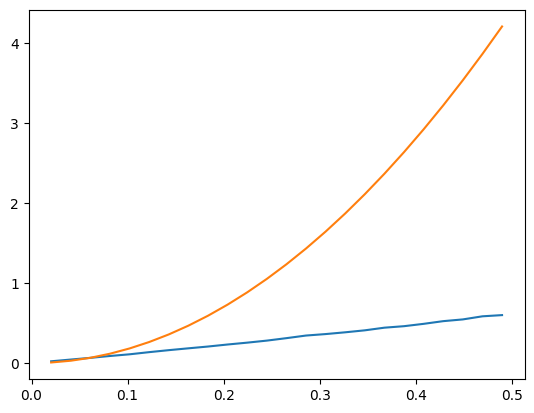

In [32]:
end_crop = -25

plt.plot(denser_theta[1:-end_crop], faked_decay_no_cal[1:-end_crop], label = 'Fake Data')
plt.plot(denser_theta[1:-end_crop], ((np.sqrt(2)*denser_theta[1:-end_crop]*J)**2), label = 'Decay')
#popt, pcov = curve_fit(fit_decay, denser_theta[1:-end_crop], faked_decay_no_cal[1:-end_crop], p0=[1, 1, 0.11, 5])
#print(popt)
#plt.plot(denser_theta[1:-end_crop], fit_decay(denser_theta[1:-end_crop], *popt), label = 'Fit')
plt.show()

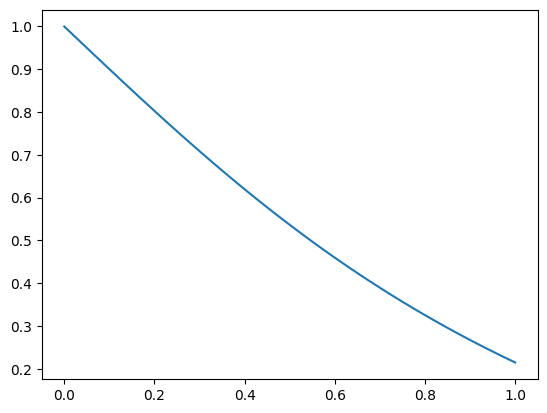

In [33]:
plt.plot(np.linspace(0, 1,50), 1-np.arctan(np.linspace(0, 1,50)))

In [34]:
print(Omega_comps**2)

[2.97127432 3.00253548 3.0342926  3.06655623 3.0993372  3.13264663
 3.16649593 3.20089684 3.23586141 3.27140203 3.3075314  3.34426262
 3.38160912 3.41958473 3.45820364 3.49748049 3.53743028 3.57806849
 3.61941103 3.66147426 3.70427504 3.74783071 3.79215912 3.83727867
 3.88320829 3.92996749 3.97757638 4.02605565 4.07542667 4.12571144]


In [35]:
print(len(theta_list))
print(len(experimental_frequencies))

9
9


[1.05340848 1.04605288 1.0390142  1.0331637  1.02568175 1.02148229
 1.01683233 1.0130576  1.01043468 1.00860497 1.00401564 1.00344156
 1.00148988 1.00045339 1.00097414 0.99996236 0.99757156 0.99628052
 0.99862441 0.99703112 0.99679611 0.99816713 0.99356786 0.9973697
 0.99674151 1.00065453 0.99985867 0.99560166 0.99797855 0.99981086]


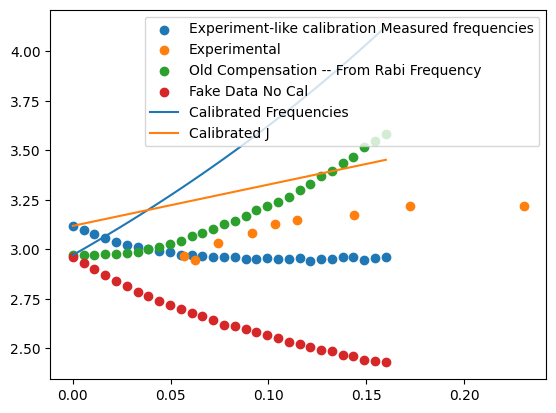

In [36]:
print(fake_frequencies/J)
plt.scatter(dense_theta, fake_frequencies, label='Experiment-like calibration Measured frequencies')
plt.scatter(theta_list, np.array(experimental_frequencies)/2*-1, label='Experimental')
plt.scatter(dense_theta, comp_frequencies, label='Old Compensation -- From Rabi Frequency')
plt.scatter(dense_theta, faked_frequency_no_cal, label='Fake Data No Cal')
plt.plot(dense_theta, Omega_comps**2, label='Calibrated Frequencies')
plt.plot(dense_theta, dense_J_cal, label='Calibrated J')
plt.legend()

In [ ]:
#I'm not sure how to correct the frequency issue. It's more non-linear than I expect

In [41]:
#print(J_calibrations)
print(J)
pseudo_experimental_oscillations = []
pseudo_experimental_leakage = []
for theta_index in range(len(theta_list)):
    theta = theta_list[theta_index]
    #J_calibrated = J_calibrations[theta_index]
    #print(J_calibrated)
    #J_calibrated = linear(theta, *popt)
    #print(J_calibrated)
    J_calibrated = Omega_comps_pseudo[theta_index]**2
    #print(theta)
    noise_dict['theta'] = theta#{'x':np.sqrt(slope), 'z':0, 'theta':theta_point}
    shot_noise = True
    pseudo_experimental_oscillations.append(gen_full_results(J_calibrated, B, obs=oscillation_obs, noise=noise_dict, shot_noise=shot_noise))
    pseudo_experimental_leakage.append(gen_full_results(J_calibrated, B, obs=leakage_obs, noise=noise_dict, shot_noise=shot_noise))

pseudo_exp_array = np.array(pseudo_experimental_oscillations)
pseudo_exp_leakage_array = np.array(pseudo_experimental_leakage)
pseudo_exp_PS = np.array([pseudo_exp_array[i]/(1-pseudo_exp_leakage_array[i]) for i in range(len(pseudo_exp_array))])
print(pseudo_exp_array.shape)

2.960784580962004


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(9, 30)


Numerical Frequencies relative to baseline
[ 1.         -0.00271     1.02185387  1.04000157 -1.06629936 -1.08483259
  1.11936657  1.2092811  -1.32774205]
[-5.8614571697737095, 0.015884566822473783, -5.989552716720554, -6.095924659484765, 6.250068001372612, 6.358699788848064, -6.561119203157756, -7.088149383714179, 7.782503149376477]
Experimental frequencies relative to baseline
[1.         0.99400182 1.0227693  1.03886743 1.05498897 1.0615045
 1.06992299 1.08530615 1.08501614]
[-5.932308689939059, -5.896725622953892, -6.067383234158808, -6.1628822934680025, -6.258520241663718, -6.297172391312177, -6.347113447060169, -6.438371128557668, -6.436650669236445]
Numerical theta from fit:
[0.21618417088653175, -2164.90299468917, 0.2946740995779621, 0.3510680299339182, -0.3708244151566263, -0.3896402101863863, 0.5562211475208322, -0.7113744743949937, -0.9080859199535173]
Inpute values of theta
[0.05673721 0.06253054 0.07411725 0.09149722 0.10308393 0.11467058
 0.14363726 0.17260395 0.23053732]


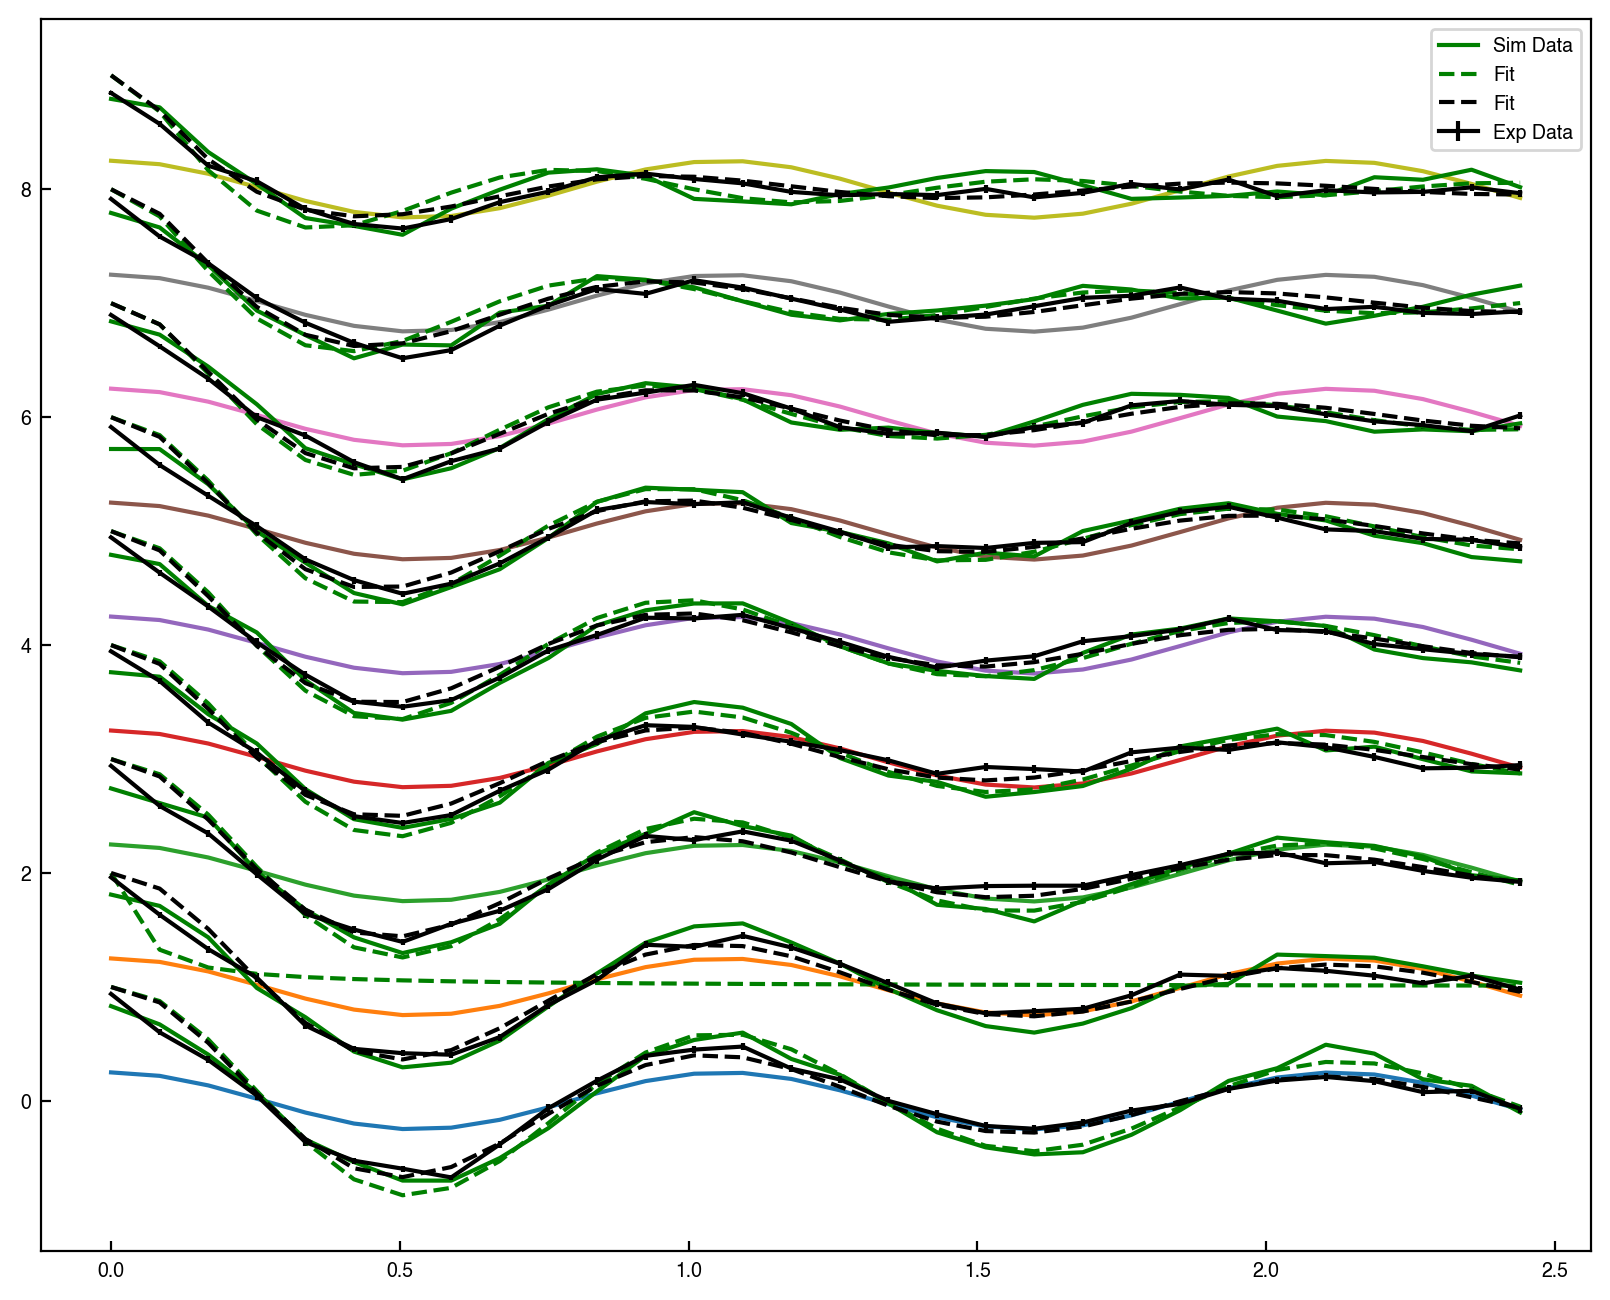

In [42]:
# Make the plot much taller vertically
plt.figure(figsize=(10, 8))
# Plot pseudo_exp_array instead of dense_theta_oscillations
for i in range(len(theta_sub_index)):
    offset = 1 * i
    if i == 0:
        plt.plot(times, pseudo_exp_array[theta_sub_index[i]] + offset, label='Sim Data', color='g')
        plt.errorbar(times, flopping_matrix[:, theta_sub_index[i]] + offset, label='Exp Data', color='k', yerr=1 / np.sqrt(shots) * flopping_std_matrix[:, theta_sub_index[i]])
    else:
        plt.plot(times, pseudo_exp_array[theta_sub_index[i]] + offset, color='g')
        plt.errorbar(times, flopping_matrix[:, theta_sub_index[i]] + offset, color='k', yerr=1 / np.sqrt(shots) * flopping_std_matrix[:, theta_sub_index[i]])



# Fit the simulation data and experimental data to the cetina_envelope_exp function
numerical_frequencies = []
experimental_frequencies = []
numerical_theta = []
for i in range(len(theta_sub_index)):
    offset = 1 * i
    # Fit the simulation data
    popt, pcov = curve_fit(cetina_envelope_exp, times, pseudo_exp_array[theta_sub_index[i]], p0=[np.sqrt(J), 0.05])
    numerical_frequencies.append(popt[1])
    numerical_theta.append(popt[0])
    if i == 0:
        plt.plot(times, cetina_envelope_exp(times, *popt) + offset, color='g', linestyle='--', label='Fit')
    else:
        plt.plot(times, cetina_envelope_exp(times, *popt) + offset, color='g', linestyle='--')
    plt.plot(times, np.cos(2*J*times)*0.25+offset, zorder=-1)

    # Fit the experimental data
    popt, pcov = curve_fit(cetina_envelope_exp, times, flopping_matrix[:, theta_sub_index[i]], p0=[np.sqrt(J), 0.05])
    experimental_frequencies.append(popt[1])
    if i == 0:
        plt.plot(times, cetina_envelope_exp(times, *popt) + offset, color='k', linestyle='--', label='Fit')
    else:
        plt.plot(times, cetina_envelope_exp(times, *popt) + offset, color='k', linestyle='--')

plt.legend()
print('Numerical Frequencies relative to baseline')
print(numerical_frequencies / numerical_frequencies[0])
print(numerical_frequencies)
print('Experimental frequencies relative to baseline')
print(experimental_frequencies / experimental_frequencies[0])
print(experimental_frequencies)

print("Numerical theta from fit:")
print(numerical_theta)
print('Inpute values of theta')
print(theta_list)

plt.show()

In [43]:
import matplotlib

[0.05673721 0.06253054 0.07411725 0.09149722 0.10308393 0.11467058]
[True, True, True, True, True, True, False, False, False]
[210 427 645 864]


'NOTE: TRYING TO GENERATE COMPARISON TO HENRY"S DATA HE SHARED'

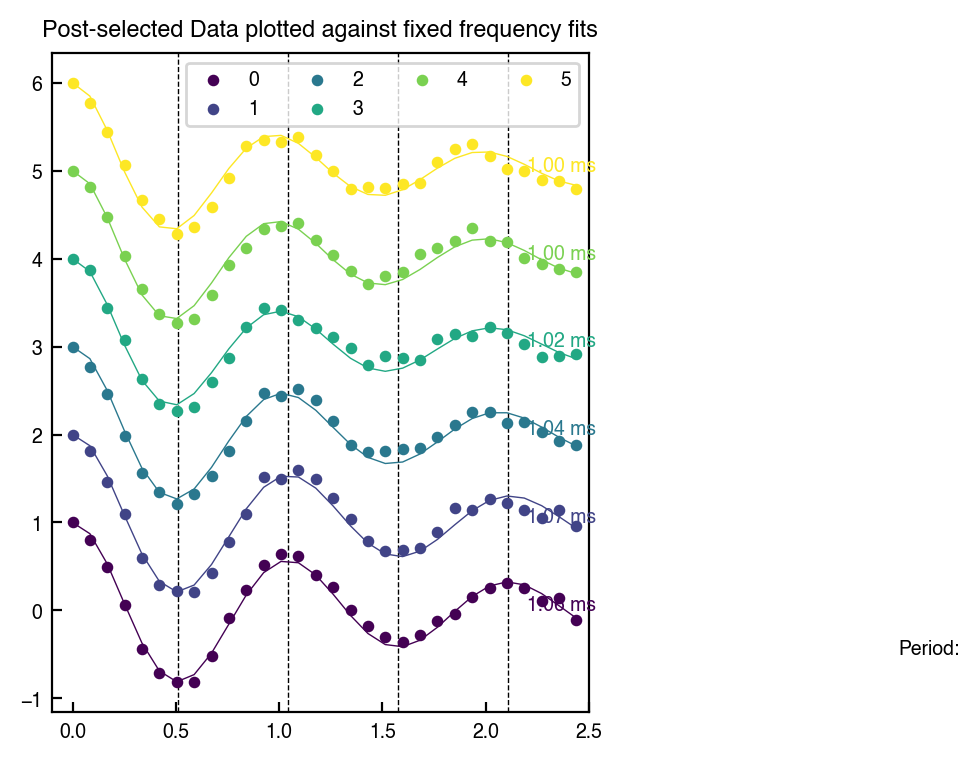

In [44]:
#to_use = flopping_matrix_smooth
#to_use = flopping_ps_smoothed
#to_use = flopping_matrix
theta_sub_index = [0,1,2,3,4,5]#,6] #REMOVE 4 FOR 20th dataset #REMOVE 6 for the old DATASET
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
print(theta_list[theta_sub_index_mask])
print(theta_sub_index_mask)
#print(to_use.shape)
to_use = flopping_matrix/(1-leakage_matrix)
#to_use = pseudo_exp_PS.T
#to_use = pseudo_exp_array.T

Post_selected = True

colors = matplotlib.cm.viridis(np.linspace(0, 1, len(theta_sub_index)))

# Plot each sub-indexed data point with scatter and line plot
for idx, theta_sub_index_val in enumerate(theta_sub_index):
    offset = idx
    color = colors[idx]
    plt.scatter(times, to_use[:, theta_sub_index_val]+idx, label=f'{theta_sub_index_val}', s=10, color=color)
    #plt.plot(times, to_use[:, theta_sub_index_val]+idx, ls='--', color=color)
    #Plot the fits against the fit_function
    popt, pcov = curve_fit(fit_function, times, to_use[:, theta_sub_index_val], p0=[0.05, J])
    plt.plot(times, fit_function(times, *popt)+idx, color=color, lw=0.5)
    frequency = popt[1]/np.pi
    period = 1/frequency
    if idx == 0:
        theta_fit_val = popt[0]
        decay_fit_val = popt[1]
    #Plot at x = 4 in the same color, expressed in MHz:
    plt.text(2.2, offset, f'{period:.2f} ms', color=color)
    # plt.plot(times, pseudo_exp_PS[theta_sub_index_val]+idx, ls='--', color=color)
    #plt.plot(times, 1-leakage_matrix[:, theta_sub_index_val], color=color)

#find the peaks in the to_use[:0] data, plot vertical lines across the entire y domain without changing the ylims of the plot
#Find the peaks in the data
dense_times = np.linspace(0, max(times), 1000)
for_peaks = fit_function(dense_times, theta_fit_val, decay_fit_val)
peak_indices = np.where(np.diff(np.sign(np.diff(np.abs(for_peaks)))) == -2)[0]+1
print(peak_indices)
for peak_index in peak_indices:
    plt.axvline(x=dense_times[peak_index], color='k', linestyle='--', lw=0.5, zorder=-1)
plt.xlim(-0.1, 2.5)
plt.legend(ncol=4)
plt.text(4, -0.5, 'Period:', color='k')
plt.title('Post-selected Data plotted against fixed frequency fits')

"""NOTE: TRYING TO GENERATE COMPARISON TO HENRY"S DATA HE SHARED"""
    

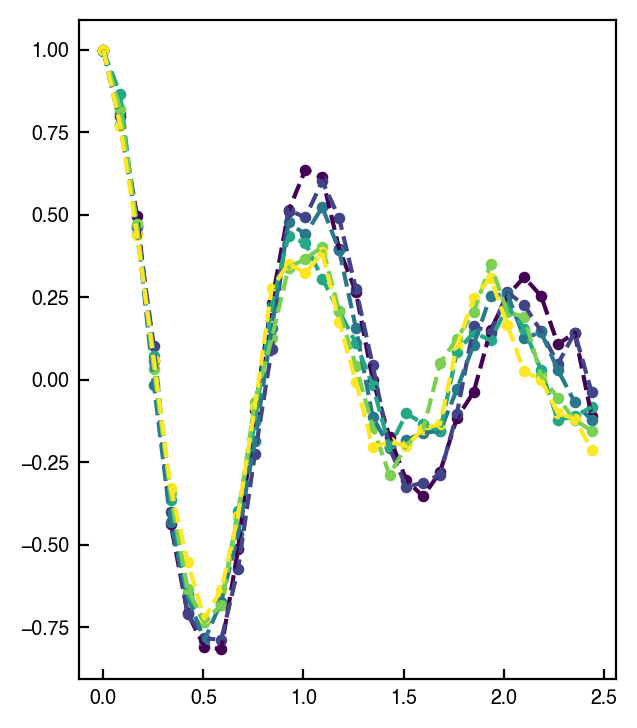

In [45]:
colors = matplotlib.cm.viridis(np.linspace(0, 1, len(theta_sub_index)))
temp_to_use = flopping_matrix/(1-leakage_matrix)
# Plot each sub-indexed data point with scatter and line plot
for idx, theta_sub_index_val in enumerate(theta_sub_index):
    color = colors[idx]
    plt.scatter(times, temp_to_use[:, theta_sub_index_val], label=f'{theta_sub_index_val}', s=10, color=color)
    plt.plot(times, temp_to_use[:, theta_sub_index_val], label=f'{theta_sub_index_val}', ls='--', color=color)
    
    #plt.scatter(times, to_use[:, theta_sub_index_val], label=f'{theta_sub_index_val}', s=10, color=color)
    #plt.plot(times, to_use[:, theta_sub_index_val], label=f'{theta_sub_index_val}', color=color,alpha=0.5) 
    
    #plt.plot(times, 1-leakage_matrix[:, theta_sub_index_val], label=f'{theta_sub_index_val}', color=color,alpha=0.2)
    #plt.plot(times, 1-leakage_matrix[:, theta_sub_index_val], label=f'{theta_sub_index_val}', color=color)


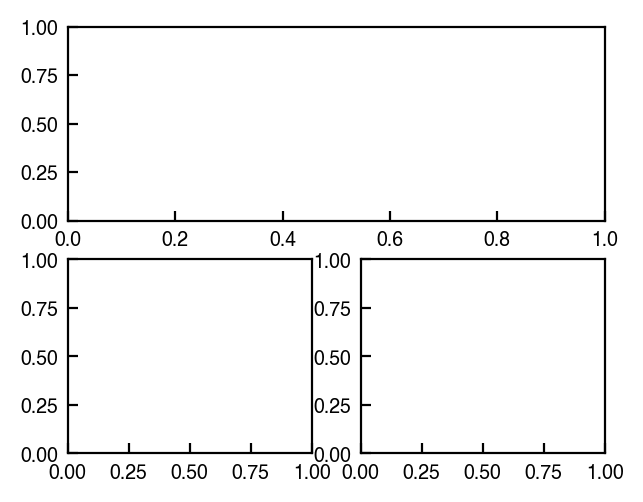

In [46]:
#import matplotlib as mpl
import matplotlib as mpl

columns = 1
rows = 2
#scol=(3+3/8) #single column width of PRL,
#dcol=2*scol # double column,
#size_col = [scol, dcol][columns-1]
#size_row = [scol, dcol][rows-1]
mmtoinch = 1/25.4
scol = 88 * mmtoinch
dcol = 180 * mmtoinch
size_col = [scol, dcol][columns-1]
if columns == 1:
    size_row = scol*rows
else:
    size_row = dcol*rows

fullwidth=6.3,
from matplotlib import cm
gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,
cm_subsection = np.linspace(0.2, 1.0, 5)
Reds = [ cm.Reds(x) for x in cm_subsection ]
mpl.rcParams.update({
    "ytick.direction": "in",
    "xtick.direction": "in",
    "axes.labelpad": 0,
    "font.size": 7,
    "legend.frameon": True,
    "figure.dpi":200,
    "figure.figsize": [size_col, size_row * gr],
    "font.family": "Helvetica",
    #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
})
fig = plt.figure()
gs = gridspec.GridSpec(3,2)  # 2x2 grid
ax_a = fig.add_subplot(gs[:2])
ax_bi = fig.add_subplot(gs[2])
ax_bii = fig.add_subplot(gs[3])



In [47]:

def create_linear_function(y_at_0_5):
    # Given points
    x1, y1 = 0.5, y_at_0_5
    x2, y2 = 1, 1
    
    # Calculate slope (a) and intercept (b)
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    
    # Return the linear function
    def linear_function(x):
        return a * x + b
    
    return linear_function

linear_func = create_linear_function(0.5)
#actual_x 
actual_x = theta_list[theta_sub_index_mask]
normalized_ZNE_points_for_color = linear_func(actual_x/max(actual_x))
#cm_subsection = np.linspace(0.2, 1.0, len(ZNE_points) )
Reds = [ cm.Reds(x) for x in normalized_ZNE_points_for_color ]
cmap = LinearSegmentedColormap.from_list('name', Reds)

colors = Reds#cmap(np.linspace(0, 1, len(ZNE_points)))

colorbar = plt.cm.ScalarMappable(cmap=cmap)
print(theta_list[theta_sub_index_mask])
labels = np.array([0.05, 0.1])
#labels = theta_list[theta_sub_index_mask]

scaled_ticks = linear_func(labels/max(actual_x))
cbar = plt.colorbar(colorbar, ax=ax_a, ticks=scaled_ticks)#, ticks=test_ticks)#normalized_ZNE_points_for_color[1:])
cbar.set_ticklabels(labels)


[0.05673721 0.06253054 0.07411725 0.09149722 0.10308393 0.11467058]


<Figure size 692.913x856.488 with 0 Axes>

In [48]:
np.min((1-leakage_matrix))

0.5700000000000001

In [49]:
print(pseudo_exp_PS.T.shape)
print(flopping_matrix.shape)

(30, 9)
(30, 9)


In [50]:


#plt.plot(to_use[:,0]*0.5+0.5)
#plt.plot((to_use[:,0])/(1-leakage_matrix[:,0])/2+0.5)
#plt.plot(to_use[:,0]/0.75)
#plt.plot(1-leakage_matrix[:,0])
#plt.plot(0.5*zero_leakage_oscillations+0.5)
#plt.plot(0.5*dense_theta_oscillations_array[baseline_index]*intercept+0.5)

#divide by leakage:

#print(flopping_std_matrix[:,index]/np.sqrt(shots))
for index in range(len(theta_list[theta_sub_index_mask])):
    index_from_mask = theta_sub_index[index]
    print(index)
    print(index_from_mask)
    if index_from_mask == 0:
        ax_a.fill_between(times, to_use[:,index_from_mask]-flopping_std_matrix[:,index_from_mask]/np.sqrt(shots), to_use[:,index_from_mask]+flopping_std_matrix[:,index_from_mask]/np.sqrt(shots), color=colors[index], alpha=0.2, zorder=100-index)
        ax_a.plot(times, to_use[:,index_from_mask], color=colors[index], lw=0.6, zorder=100-index, label='Experimental')
    else:
        ax_a.fill_between(times, to_use[:,index_from_mask]-flopping_std_matrix[:,index_from_mask]/np.sqrt(shots), to_use[:,index_from_mask]+flopping_std_matrix[:,index_from_mask]/np.sqrt(shots), color=colors[index], alpha=0.2, zorder=100-index)#, label='Experimental Error')
        ax_a.plot(times, to_use[:,index_from_mask], color=colors[index], lw=0.6, zorder=100-index)
current_ylims = ax_a.get_ylim()


0
0
1
1
2
2
3
3
4
4
5
5


In [51]:
ZNE_function = lambda x, y, weights: converge_ZNE_loocv(x, y, debug=False, y_error=weights, return_cov=True, remove_first=True, return_order=True)
ZNE_function_fixed_order = lambda x, y, weights, order: order_poly_ZNE(x, y, debug=False, weights=weights, return_cov=True, remove_first=True, order=order)


In [52]:
print(theta_list)
print(theta_sub_index_mask)
theta_list[theta_sub_index_mask]
to_use.shape

[0.05673721 0.06253054 0.07411725 0.09149722 0.10308393 0.11467058
 0.14363726 0.17260395 0.23053732]
[True, True, True, True, True, True, False, False, False]


(30, 9)

In [53]:
ZNE_data = np.zeros(len(times))
ZNE_data_errors = np.zeros(len(times))
ZNE_funcs = []
orders = np.ones(len(times), dtype=int)+2
for i in range(len(times)):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func, error, order = ZNE_function(theta_list[theta_sub_index_mask], to_use[i,theta_sub_index_mask], weights=flopping_std_matrix[i, theta_sub_index])#np.sqrt(flopping_std_matrix[i,theta_sub_index_mask]*0+1 + 1/shots)*weights_comp)
    if 1:#np.abs(order - orders[-1]) > 1:
        #print('Order jump')
        #print(order)
        #print(orders[-1])
        
        fit_func, error = ZNE_function_fixed_order(theta_list[theta_sub_index_mask], to_use[i,theta_sub_index_mask], weights=flopping_std_matrix[i, theta_sub_index], order=orders[-1])#np.sqrt(flopping_std_matrix[i,theta_sub_index_mask]*0+1 + 1/shots)*weights_comp)
        order = orders[-1]
        error = error[0,0]
    ZNE_funcs.append(fit_func)
    ZNE_data[i] = fit_func(0)
    ZNE_data_errors[i] = error
    orders[i] = order

print(order)

#ZNE_data = savgol_filter(ZNE_data, 6, 2)
#ZNE_data_smooth = ZNE_data_raw#savgol_filter(ZNE_data_raw, 6, 2)


[nan, 0.00010333851238915334, 0.00010833015851858857, 8.082378452146339e-05, 0.0001363020636574757]
3
[1 0 0]
[[ 2.18801628e-05 -9.63186673e-03  7.19754706e-02]
 [-9.63186673e-03  4.46190627e+00 -3.38700522e+01]
 [ 7.19754706e-02 -3.38700522e+01  2.58899108e+02]]
7.085031977040833e-05
0.004677623628625022
[nan, 0.038419992745003115, 0.04228644489450885, 0.03241681714464073, 0.05812465421840891]
3
[1 0 0]
[[ 1.19387119e-02 -5.08155781e+00  3.75090471e+01]
 [-5.08155781e+00  2.29718420e+03 -1.72687012e+04]
 [ 3.75090471e+01 -1.72687012e+04  1.30802985e+05]]
0.022511775966356482
0.10926441278444311
[nan, 0.013837251210199873, 0.008211844013138408, 0.013394251585764388, 0.016186104109657123]
2
[1 0]
[[ 2.70920916e-04 -2.94431497e-02]
 [-2.94431497e-02  3.95153153e+00]]
0.0004107982345341203
0.016459675456234578
[nan, 0.04865051662655351, 0.05067511143939789, 0.048505501422180186, 0.09947516384464719]
3
[1 0 0]
[[ 2.10186886e-02 -8.90658147e+00  6.54098061e+01]
 [-8.90658147e+00  4.00034643

In [54]:
print(orders)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


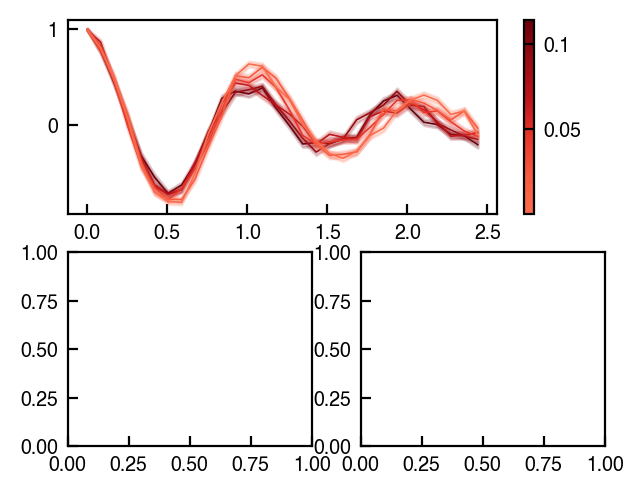

In [55]:
fig

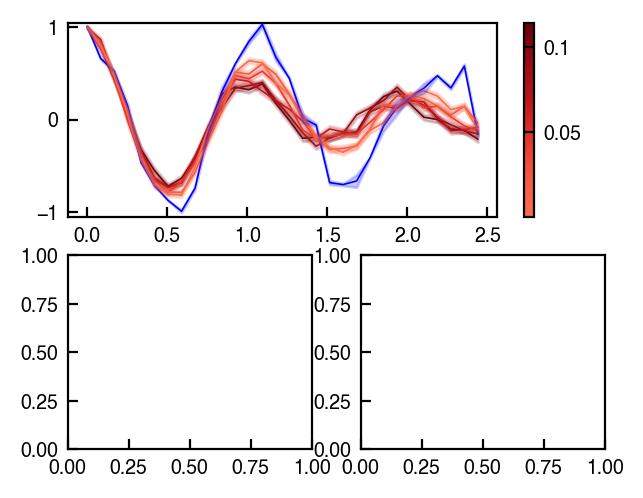

In [56]:

ax_a.fill_between(times, ZNE_data-ZNE_data_errors, ZNE_data+ZNE_data_errors, color='blue', alpha=0.2, zorder=1000)
ax_a.plot(times, ZNE_data, color="blue", label="Zero Noise Extrapolation", zorder=-1, lw=0.6)#, linestyle="--")
ax_a.set_ylim(-1.05, 1.05)
#ax_a.scatter(times, orders/max(orders)*2 -1)

fig

In [57]:
if not Post_selected:
    ax_a.plot(times, dense_theta_oscillations_array[0], color='k', label='Zero Temperature')
else:
    ax_a.plot(times, dense_theta_oscillations_array[0]/(1-dense_theta_leakage_array[0]), color='k', label='Zero Temperature')

In [58]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

index_to_plot = 21 #9 is first peak
#index_to_plot = 245
#ax_a.vlines(times[index_to_plot],-10, 10, linestyle=":")
#Converting this to an inset:
#ax_a.set_ylim(current_ylims)


for theta_index in range(len(theta_sub_index)):
    #ax_bi.scatter(thetas[theta_index], stagmag_averaged[theta_index, index_to_plot], color=colors[theta_index], s=10)
    #WARNING THIS IS HARDCODED
    print(colors)
    print(colors[theta_index])
    index = theta_sub_index[theta_index]
    ax_bi.errorbar(theta_list[index], to_use[index_to_plot, index], yerr=np.sqrt( 1/shots), color=colors[theta_index], elinewidth=1, capsize=2, capthick=1,markersize = 2, fmt='o', zorder=100-theta_index)
#ax_bi.scatter(thetas[theta_index], stagmag_averaged[theta_index, index_to_plot], color=colors[theta_index], label=r"Experimental Points", s=10, zorder=100)
ax_bi.errorbar(theta_list[index], to_use[index_to_plot, index], yerr=np.sqrt( 1/shots), color=colors[theta_index], label=r"Experimental Points", zorder=100, markersize = 2, fmt='o', elinewidth=1, capsize=2, capthick=1)
#ax_a.vlines(times[index_to_plot],-10, 10, linestyle=":")

#Plot ideal:
#ax_a.plot(times, np.cos(J*2*times), label = 'Ideal', color = 'r', linestyle = '--')


#Generating the ZNE data and errors for the ax_bi/inset
#ZNE_function = lambda x, y, weights: converge_ZNE_loocv(x, y, debug=False, y_error=weights, return_cov=True, remove_first=False)
#ZNE_function =lambda x, y, weights: (order_poly_ZNE(x, y, debug=True, weights=weights, remove_first=True, order=3),0)
#ZNE_function_output, std = ZNE_function(theta_list[theta_sub_index_mask], to_use[index_to_plot, theta_sub_index_mask], (flopping_std_matrix[index_to_plot,theta_sub_index_mask]*0+1)/np.sqrt(shots))
#ZNE_data_plotting = ZNE_function_output(0)
ZNE_function_output = ZNE_funcs[index_to_plot]
std = ZNE_data_errors[index_to_plot]
ZNE_data_plotting = ZNE_funcs[index_to_plot](0)
ax_bi.set_xlim([0-(max(theta_list[theta_sub_index_mask])/10), max(theta_list[theta_sub_index_mask])*1.1])   
ax_bi.plot(dense_theta, ZNE_function_output(dense_theta), color="blue",label='Extrapolating Polynomial', zorder=-1)#, linestyle="--")
ax_bi.errorbar(0, ZNE_data_plotting, yerr=std, color="blue", elinewidth=1, capsize=2, capthick=1, fmt='o', markersize=2)
#ax_bi.set_ylim([0, 1])

if Post_selected:
    ax_bi.fill_between(dense_theta, dense_theta_oscillations_array[:,index_to_plot]/(1-dense_theta_leakage_array[:,index_to_plot])-1/np.sqrt(shots), dense_theta_oscillations_array[:,index_to_plot]/(1-dense_theta_leakage_array[:,index_to_plot])+1/np.sqrt(shots), color='k', alpha=0.1, zorder=1000, label='Numerical Error')
    ax_bi.scatter(dense_theta, dense_theta_oscillations_array[:,index_to_plot]/(1-dense_theta_leakage_array[:,index_to_plot]), s=0.5, color='k')
else:
    #Plotting the dense black points from the simulation data. See plots above -- simulation =/= experimental at the moment
    ax_bi.fill_between(dense_theta, dense_theta_oscillations_array[:,index_to_plot]/intercept-1/np.sqrt(shots), dense_theta_oscillations_array[:,index_to_plot]/intercept+1/np.sqrt(shots), color='k', alpha=0.1, zorder=1000, label='Numerical Error')
    ax_bi.scatter(dense_theta, dense_theta_oscillations_array[:,index_to_plot]/intercept, s=0.5, color='k')



#ax_bi.scatter(thetas, stagmag_averaged[:, index_to_plot], s=0.5)#, label='Numerical Points')

# subplot_2_ylims = ax_bi.get_ylim()
# ZNE_function = lambda x, y: converge_ZNE_loocv(x, y, debug=False, return_cov=True, remove_first=False, y_error=error_stats)
# print(thetas[indexes_mask])
# print(error_stats)
# ZNE_function_output, std = ZNE_function(thetas[indexes_mask], stagmag_averaged[:, index_to_plot][indexes_mask])
# ZNE_data_plotting = ZNE_function_output(0)
# ax_bi.set_xlim([0-(max(thetas[indexes_mask])/10), max(thetas[indexes_mask])*1.1])
# ax_bi.plot(thetas, ZNE_function_output(thetas), color="blue",label='Extrapolating Polynomial', zorder=-1)#, linestyle="--")
# print(std)
# ax_bi.errorbar(0, ZNE_data_plotting, yerr=std, color="blue", elinewidth=1, capsize=2, capthick=1, fmt='o', markersize=2)
# ax_bi.set_ylim([subplot_2_ylims[0], max([ZNE_function_output(0)+0.03, subplot_2_ylims[1], stagmag_averaged[0,index_to_plot]*1.05])])

# ax_bi.hlines(stagmag_averaged[0,index_to_plot], 0, max(thetas[indexes_mask]), linestyle="--", color="black", label="Noiseless")



[(0.9844982698961937, 0.42306805074971165, 0.2975778546712803, 1.0), (0.9673356401384082, 0.34918877354863515, 0.24775086505190314, 1.0), (0.9123414071510957, 0.2071510957324106, 0.1621683967704729, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.5946174548250673, 0.04613610149942329, 0.07558631295655516, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]
(0.9844982698961937, 0.42306805074971165, 0.2975778546712803, 1.0)
[(0.9844982698961937, 0.42306805074971165, 0.2975778546712803, 1.0), (0.9673356401384082, 0.34918877354863515, 0.24775086505190314, 1.0), (0.9123414071510957, 0.2071510957324106, 0.1621683967704729, 1.0), (0.7364705882352941, 0.08, 0.10117647058823528, 1.0), (0.5946174548250673, 0.04613610149942329, 0.07558631295655516, 1.0), (0.403921568627451, 0.0, 0.05098039215686274, 1.0)]
(0.9673356401384082, 0.34918877354863515, 0.24775086505190314, 1.0)
[(0.9844982698961937, 0.42306805074971165, 0.2975778546712803, 1.0), (0.9673356401384082, 0.3491887735486

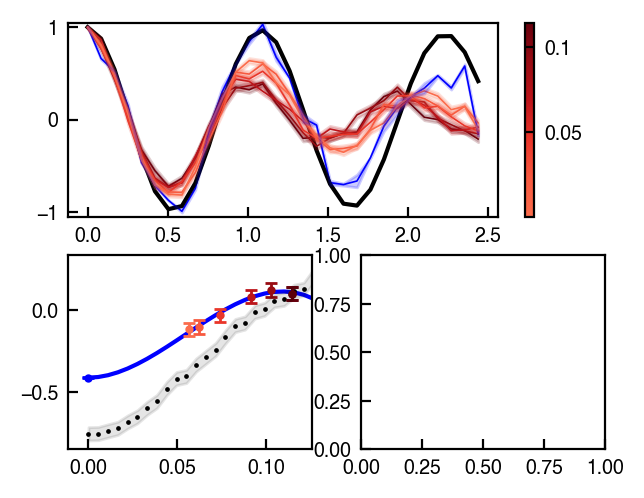

In [59]:
fig

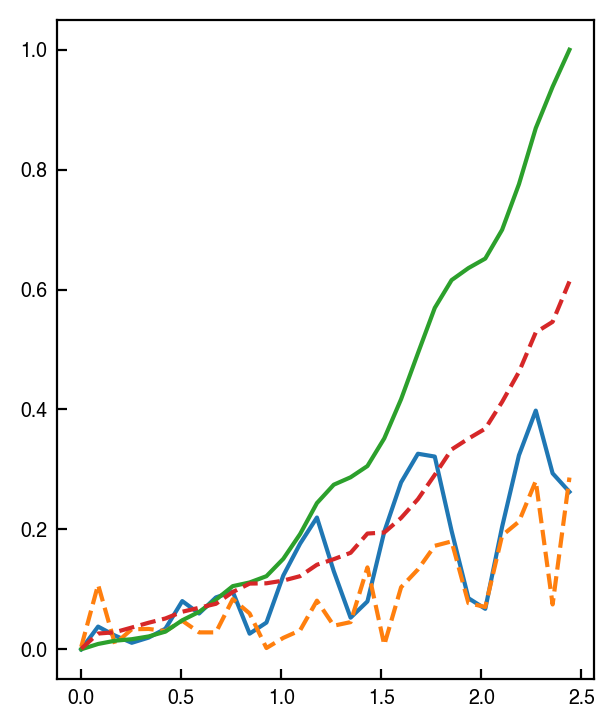

In [60]:
ideal = dense_theta_oscillations_array[0,:]/(1-dense_theta_leakage_array[0,:])

error_exp = np.abs((to_use[:,0] - ideal))#/np.cos(J*2*times))

error_ZNE = np.abs((ZNE_data - ideal))#/np.cos(J*2*times))
#error_PS_ZNE = np.abs((ZNE_data_smooth_ps - np.cos(J*2*times)))#/np.cos(J*2*times))

#plt.plot(times, error_exp, label='Experimental', color='k')
#plt.plot(times, error_ZNE, label='ZNE', color='b')
#plt.plot(times, error_PS_ZNE, label='ZNE + PS', color='orange')
#plt.vlines(times[peak_indices], 1e-3, 1, colors='k')
#plt.plot(times, to_use[:,0], label='Experimental', color='k')
#plt.plot(times, ZNE_data_smooth, label='ZNE', color='b')
#plt.plot(times, ZNE_data_smooth_ps, label='ZNE + PS', color='orange')
#plt.plot(times, np.cos(J*2*times), label='Ideal', color='r', linestyle='--')

#Plotting realtive errors:
relative_error_experimental = np.abs((to_use[:,0] - np.cos(J*2*times))/np.cos(J*2*times))
relative_error_ZNE = np.abs((ZNE_data_smooth - np.cos(J*2*times))/np.cos(J*2*times))
relative_error_PS_ZNE = np.abs((ZNE_data_smooth_ps - np.cos(J*2*times))/np.cos(J*2*times))

cumulative_relative = np.cumsum(relative_error_experimental)/np.arange(1, len(error_exp)+1)
cumulative_relative_ZNE = np.cumsum(relative_error_ZNE)/np.arange(1, len(error_exp)+1)
cumulative_relative_PS_ZNE = np.cumsum(relative_error_PS_ZNE)/np.arange(1, len(error_exp)+1)

cumulative_exp = np.cumsum(error_exp)#/np.arange(1, len(error_exp)+1)
cumulative_ZNE = np.cumsum(error_ZNE)#/np.arange(1, len(error_exp)+1)
#cumulative_PS_ZNE = np.cumsum(error_PS_ZNE)
plt.plot(times, error_exp/2)
plt.plot(times, error_ZNE/2, ls='--')
normalizer = np.max(np.concatenate((cumulative_exp, cumulative_ZNE)))
plt.plot(times, cumulative_exp/normalizer)
plt.plot(times, cumulative_ZNE/normalizer, ls='--')

normalizer_relative = np.max(np.concatenate((cumulative_relative, cumulative_relative_ZNE)))
#plt.plot(times, cumulative_relative/normalizer_relative)
#plt.plot(times, cumulative_relative_ZNE/normalizer_relative, ls='--')
##plt.plot(times, ideal)
#plt.plot(times, ZNE_data)
#plt.plot(times, ZNE_data_smooth)

shot_noise_cumulative = np.array([(i+1) * 1/np.sqrt(shots) for i in range(len(times))])



ax_bii.scatter(times, cumulative_exp, label='Experimental (PS)', color=colors[0], s=0.5)
#ax_bii.scatter(times, relative_error_ZNE, label='ZNE', color='b', s=0.5)
ax_bii.scatter(times, cumulative_ZNE, label='ZNE (PS)', color='b', s=0.5)
#ax_bii.scatter(times, shot_noise_cumulative, label='Shot Noise', color='k', s=0.5)

#ax_bii.set_yscale('log')
peak_indices = np.where(np.diff(np.sign(np.diff(np.abs(to_use[:,0])))) == -2)[0]
#ax_bii.vlines(times[peak_indices], 1e-3, 1, colors='k')
#ax_bii.legend()

In [61]:
#ax_bii.text(0.5, 0.5, 'Earlier Data, with slow ramp', ha='center', va='center', transform=ax_bii.transAxes)

In [62]:
ax_a.set_xlabel(r'Time ($\mathrm{ms}$)', usetex=True)
ax_a.set_ylabel(r'$\langle \sigma^z_0 - \sigma^z_1 \rangle$', usetex=True)
ax_a.legend()
ax_bi.set_xlabel(r'Temperature ($\theta$)', usetex=True)
cbar.set_label(r'$\theta$', usetex=True)
ax_bi.set_ylabel(r'$\langle \sigma^z_0 - \sigma^z_1 \rangle$', usetex=True)
ax_bii.set_xlabel(r'Time ($\mathrm{ms}$)', usetex=True)
ax_bii.set_ylabel('Cumulative Error')


fig.tight_layout(pad=0.1, h_pad=0.2, w_pad=0.2)


x, y = -.1, -3.5  # Position in data coordinates
#ax_z = ax_a.inset_axes([-2.7, -3.38, 30.5, 1.97],
#                  xlim  = (32, 34), ylim= (-0.05, .2))
ax_z = inset_axes(ax_a, 
                  width="100%",  # Reduce width to make inset smaller
                  height="100%", # Reduce height to match
                  bbox_to_anchor=(x, y, 1.5, 2.05),
                  bbox_transform=ax_a.transData,  # Use data coordinates
                  loc='center')

target_time = times[index_to_plot]
print(target_time)
x_inset_range = (target_time-0.1, target_time+0.1)
y_inset_range = (0, np.sign(np.cos(2*J*times[index_to_plot])*1))
ax_z.set_xlim(x_inset_range)
ax_z.set_ylim(y_inset_range)
inset_zoom = ax_a.indicate_inset_zoom(ax_z, edgecolor="k", )
connector_lines = inset_zoom[1]  # The connector lines are returned as a tuple
connector_lines[0].set_visible(False)  # Hide the lower-left connector line
connector_lines[1].set_visible(True)   # Show the upper-left connector line
connector_lines[2].set_visible(False)   # Show the lower-right connector line
#Set the z order and transparaency of the connector line
connector_lines[2].set_zorder(-1)
connector_lines[3].set_visible(True)  # Hide the upper-right connector line
#Turn off all all the axes for ax_z:
ax_z.axis('off')
#Turn EVERYTHING OFF, leave only the connectors:
ax_z.set_xticks([])
ax_z.set_yticks([])
ax_z.set_xticklabels([])
ax_z.set_yticklabels([])
ax_z.set_xlabel("")
ax_z.set_ylabel("")

ax_bii.legend(ncol=2)


1.7667890625


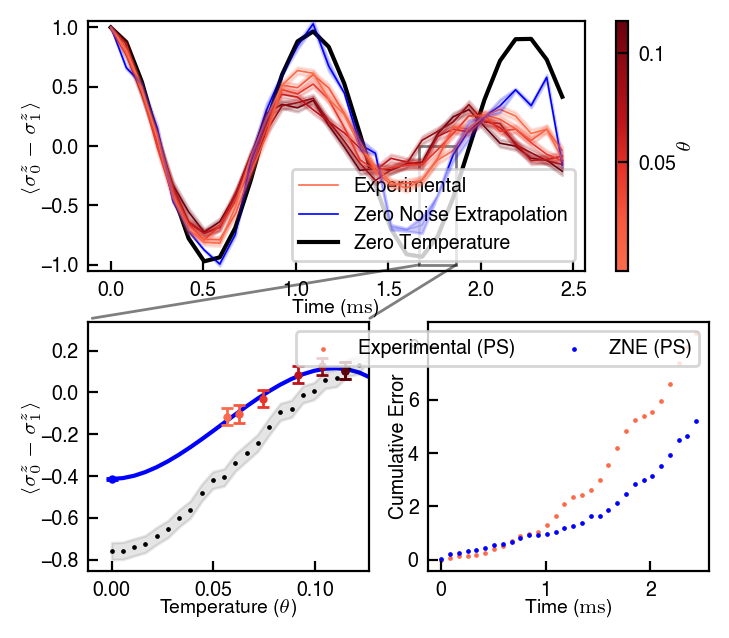

In [63]:
fig

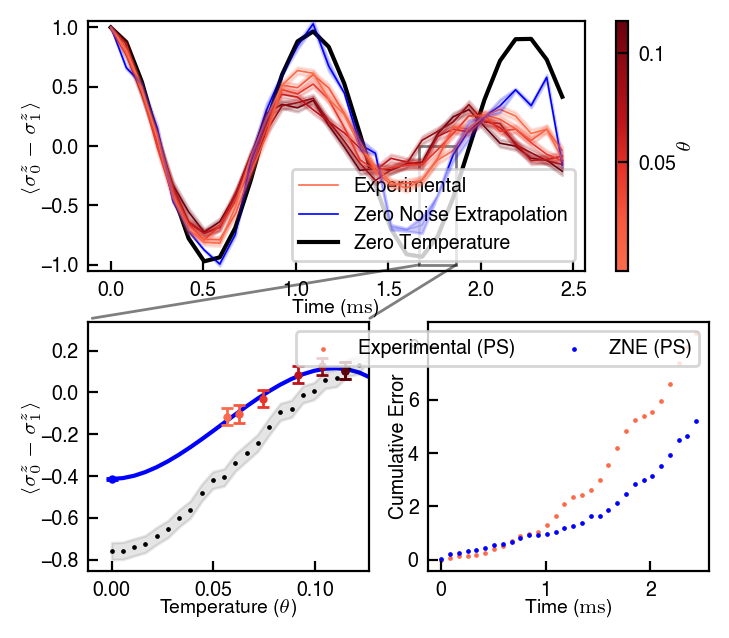

In [64]:
fig

In [65]:
# fig.savefig('Figure_4_v2.pdf')#, bbox_inches='tight')
# fig.savefig('Figure_4_v2.png', dpi=600)#, bbox_inches='tight')
# fig.savefig('Figure_4_v2.svg')#, bbox_inches='tight')